# <center><b>Decision trees for classification and regression</b> </center><a class="tocSkip">

## **Introduction**

In this project, we study **decision trees** with the primary goal of understanding their mechanics by **implementing a decision tree from scratch**. To build intuition first, we start with a simple **one-dimensional toy regression** example that shows how a tree makes **piecewise-constant predictions** by recursively splitting the input space to reduce prediction error. We then move to a practical application using a real healthcare dataset of **70,000 patients**, where the task is to predict **cardiovascular disease** from demographic variables, clinical measurements (e.g., blood pressure, cholesterol, glucose), and lifestyle indicators (e.g., smoking and physical activity). This section includes standard preprocessing (converting age from days to years and one-hot encoding categorical medical variables) and model selection using a stratified train/holdout split with **cross-validated tuning of `max_depth`** via `GridSearchCV`, evaluated primarily with **accuracy**.

With this foundation in place, we implement a **custom decision tree** that supports both **classification and regression**, including common split criteria (**Gini** and **entropy** for classification; **variance** and **mean absolute deviation from the median** for regression), as well as prediction and probability outputs. Finally, we validate the implementation through targeted experiments on synthetic data and benchmark datasets, using **accuracy** for classification and **mean squared error (MSE)** for regression, and applying cross-validation to compare criteria and select an appropriate tree depth.


In [49]:
# we don't like warnings
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

sns.set_theme() # the modern equivalent of sns.set(). 
# sns.set_theme() applies Seaborn’s default aesthetic settings (grid style, font sizes, color palette, etc.) to Matplotlib globally.
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina' # It tells the notebook to render plots inline using higher-resolution (“retina”) images. 

## **1. Decision trees for regression: a toy example**

Let's consider the following one-dimensional regression problem. We need to build a function $\large a(x)$ to approximate the dependency $\large y = f(x)$ using the mean-squared error criterion: $\large \min \sum_i {(a(x_i) - f(x_i))}^2$.

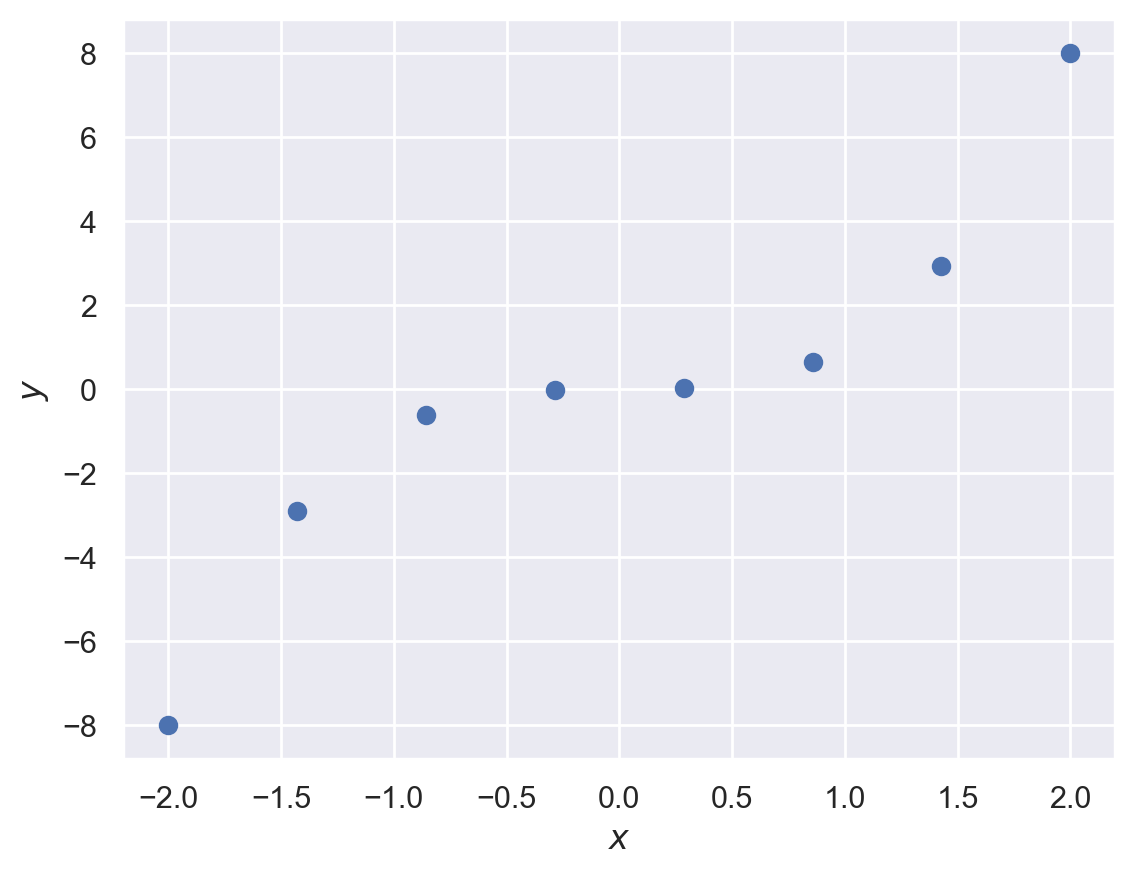

In [50]:
X = np.linspace(-2, 2, 8)
y = X ** 3  # original dependecy

plt.scatter(X, y)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$");

Let's make several steps to build a decision tree. In the case of a **regression** task, at prediction time, the decision tree returns the **average value** for all observations in this leaf.

<div style="font-size:24px; color:hotpink;"> 

For a **regression decision tree**, once an input lands in a leaf at prediction time, the model outputs **the mean (average) of the target values** of the training samples that ended up in that leaf.

More precisely, during training the tree minimizes something like **mean squared error**, and the optimal constant prediction for a leaf under MSE is the **average** of the targets in that region.
</div>

Tiny footnote:

* Some implementations *could* store a different statistic if you change the loss function, but for standard CART-style regression trees (like in scikit-learn), it’s the **mean**.
* Classification trees do voting. Regression trees do averaging.




Let's start with a tree of depth 0, i.e. all observations placed in a single leaf. 

<br>We'll need to build a tree with only one node (also called **root**) that contains all train observations (instances). 
<br>How will predictions of this tree look like for $x \in [-2, 2]$? <br> 

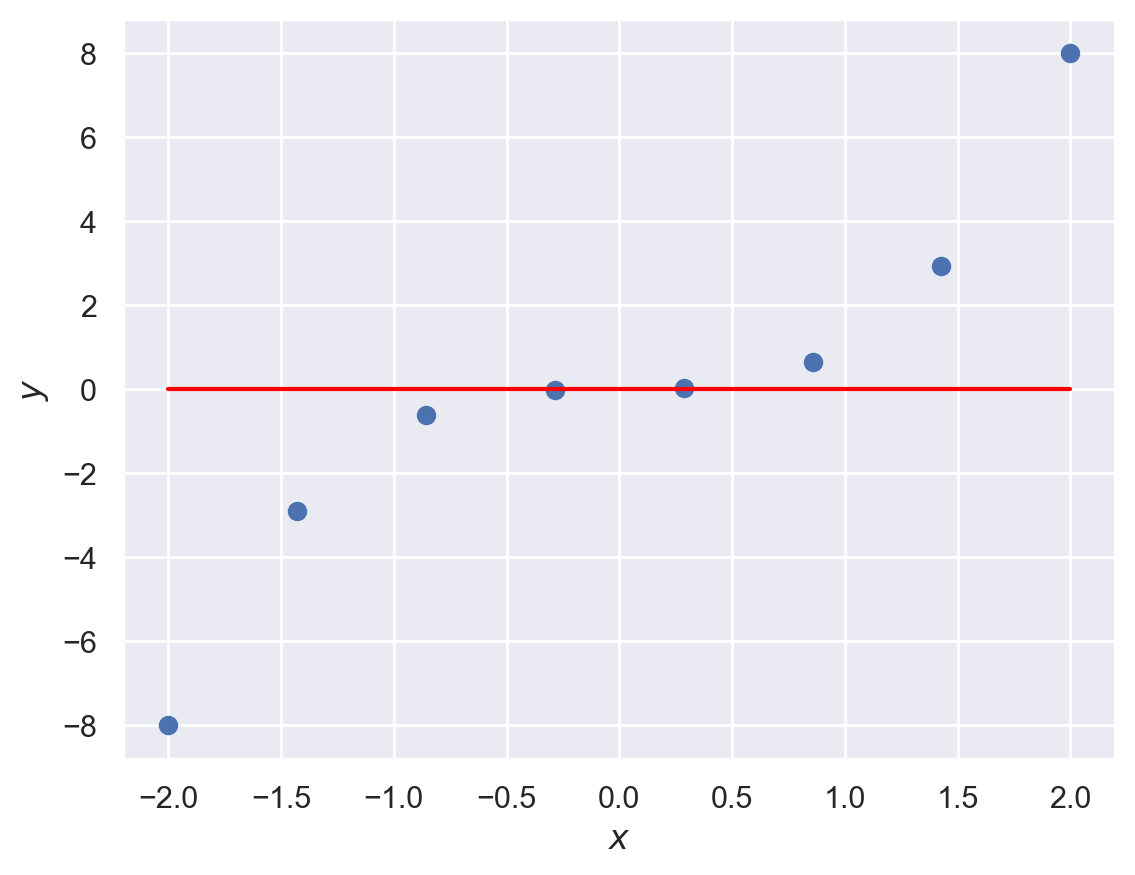

In [51]:
xx = np.linspace(-2, 2, 100)
predictions = [np.mean(y) for _ in xx]

plt.scatter(X, y)
plt.plot(xx, predictions, c="red")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$");

**Making first splits.**
<br>Let's split the data according to the followin.g condition $[x < 0]$. It gives us the tree of depth 1 with two leaves. To clarify, for all instances with $x \geqslant 0$ the tree will return some value, for all instances with $x < 0$ it will return another value Let's create a similar plot for predictions of this tree.

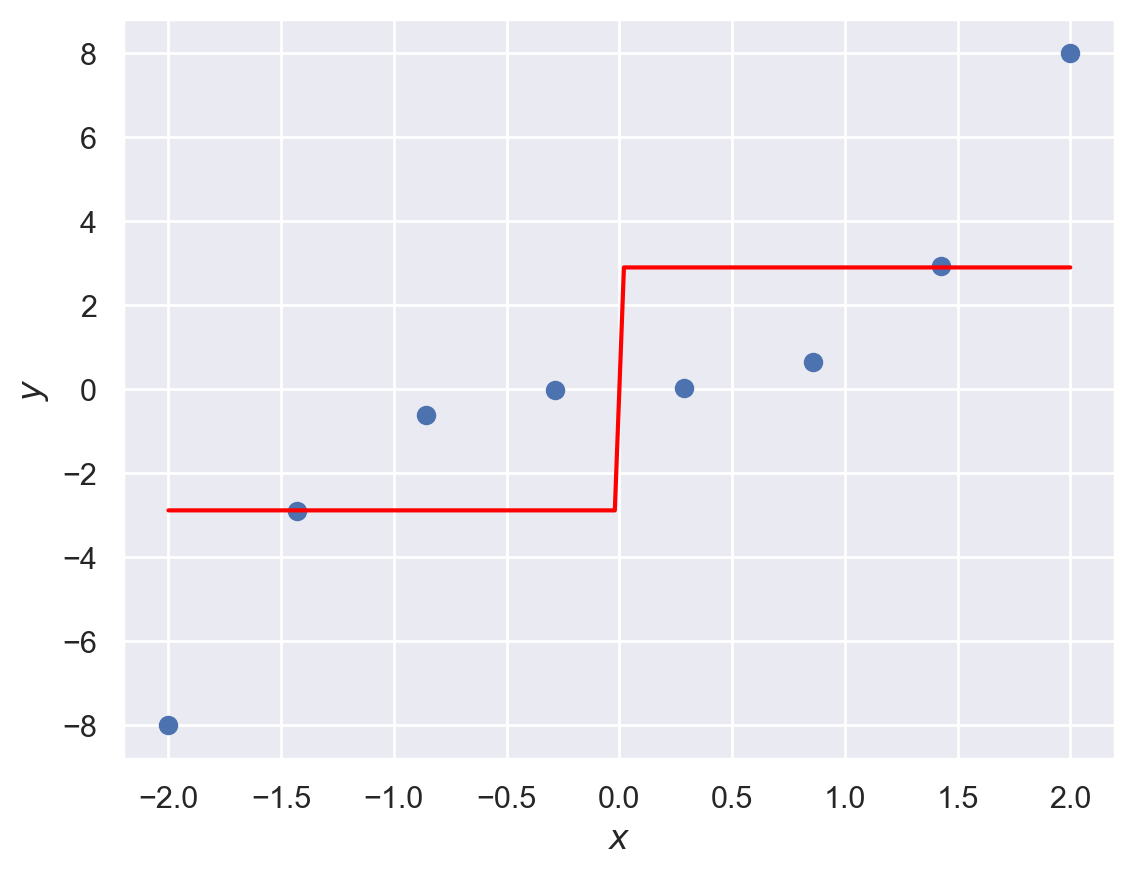

In [52]:
# y[X < 0] # array([-8.        , -2.37037037, -0.2962963 ])
# y[X >= 0] # array([0.        , 0.2962963 , 2.37037037, 8.        ])
# y[X < 0].mean() # -3.55
# y[X >= 0].mean() # 2.66

predictions = [np.mean(y[X < 0]) if x < 0 else np.mean(y[X >= 0]) for x in xx]

plt.scatter(X, y)
plt.plot(xx, predictions, c="red")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$");

In a decision tree, each internal node is split by choosing a **feature** $j$ and a **threshold** $t$ that optimize a splitting criterion.  
For **regression trees**, a common choice is **variance reduction** (equivalently, reduction in mean squared error).

Let $X \in \mathbb{R}^{n \times d}$ be the feature matrix and $y \in \mathbb{R}^{n}$ the target vector for the samples currently in a node.  
For a candidate split $[x_j < t]$, define the left and right subsets:
$$
(X_l, y_l) = \{(x_i, y_i) : x_{i,j} < t\}, \qquad
(X_r, y_r) = \{(x_i, y_i) : x_{i,j} \ge t\},
$$
with sizes $n=|X|$, $n_l=|X_l|$, and $n_r=|X_r|$.

The **split gain** (variance reduction) is
$$
Q(X,y,j,t)
= D(y) - \frac{n_l}{n}D(y_l) - \frac{n_r}{n}D(y_r),
$$
where $D(\cdot)$ is the variance/MSE of the targets in a set:
$$
D(y) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \bar{y})^2,
\qquad
\bar{y}=\frac{1}{n}\sum_{i=1}^{n}y_i.
$$

At each node, the algorithm chooses $(j,t)$ that maximizes $Q(X,y,j,t)$, i.e., yields the largest reduction in target variance.

In the **1D case** ($d=1$), there is only one feature, so the criterion depends only on the threshold $t$:
$$
Q_{\text{1D}}(X,y,t) \equiv Q(X,y,1,t).
$$


In [53]:
def regression_var_criterion(X, y, t):
    pass
    X_left, X_right = X[X < t], X[X >= t]
    y_left, y_right = y[X < t], y[X >= t]
    return(
        np.var(y)
        - X_left.shape[0]/X.shape[0] * np.var(y_left)
        - X_right.shape[0]/X.shape[0] * np.var(y_right)
    )

Now we plot the criterion $Q_{\text{1D}}(X,y,t)$ as a function of the threshold $t$ over the interval $[-1.9,1.9]$.

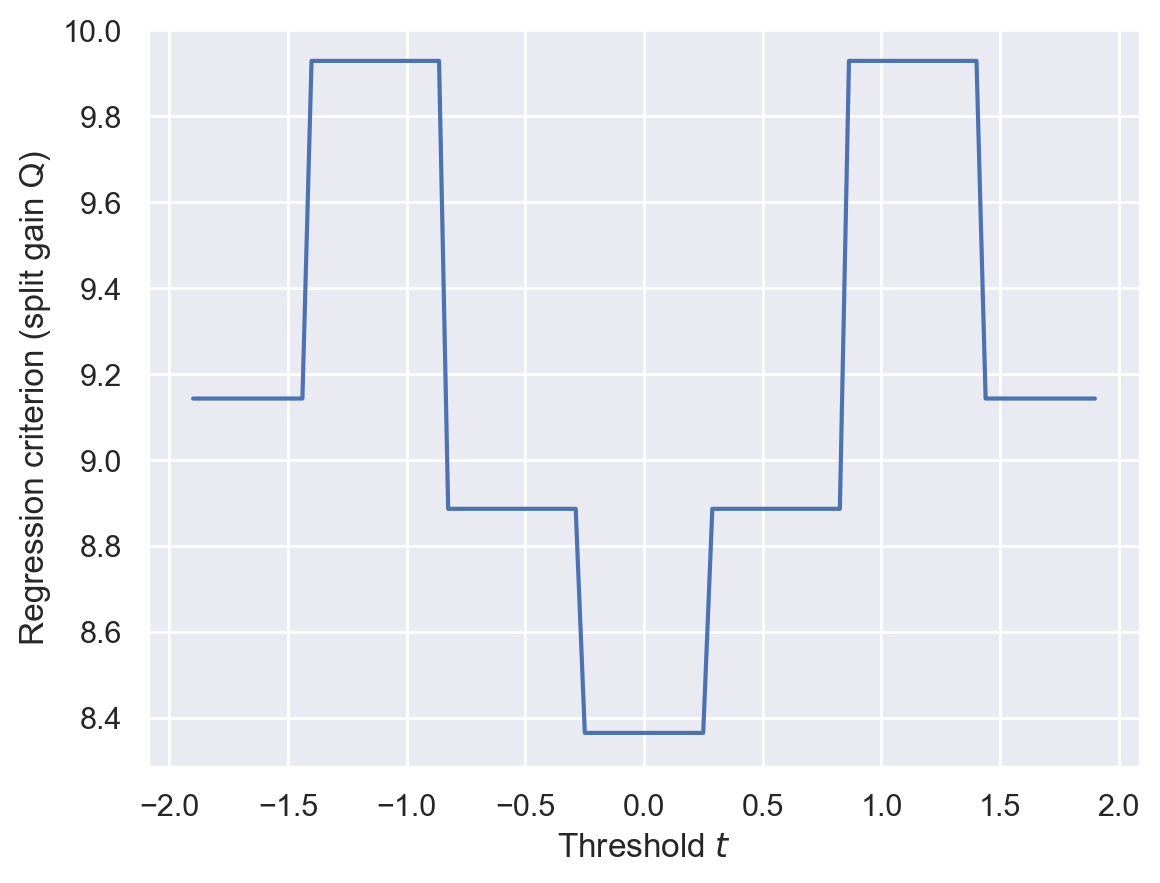

In [54]:
thresholds = np.linspace(-1.9, 1.9, 100)
X = np.linspace(-2, 2, 8)
y = X ** 3  # original dependecy
crit_by_thres = [regression_var_criterion(X, y, thres) for thres in thresholds]

plt.plot(thresholds, crit_by_thres)
plt.xlabel(r"Threshold $t$")
plt.ylabel(r"Regression criterion (split gain Q)");

As you can see, among the thresholds considered, $Q_{\text{1D}}(t)$ attains its minimum for thresholds around $t=0$, so splitting near $0$ yields the **smallest variance reduction** (lowest split gain).  
To understand *why* this happens and build some intuition, it helps to rewrite the split criterion in a form that makes its meaning more transparent.

Using the population variance $D(\cdot)$ (as in `np.var`, `ddof=0`), the split gain can be rewritten as the **between-group variance** (an ANOVA-style decomposition):
$$
Q(t)=\frac{n_l}{n}\big(\mu_l-\mu\big)^2+\frac{n_r}{n}\big(\mu_r-\mu\big)^2,
$$
where $\mu$ is the mean target value in the parent node and $\mu_l,\mu_r$ are the means in the left and right child nodes.  
This interpretation is immediate: $Q(t)$ is large when the split produces two groups with **very different average targets**, and small when the child means remain close to the parent mean.

In our data, $y=x^3$ is an **odd, symmetric** function around $0$, so the overall mean is $\mu\approx 0$. A threshold near $t=0$ sends both **small-magnitude** and **large-magnitude** values to each side (each child still contains values close to $0$ along with more extreme values), which keeps $\mu_l$ and $\mu_r$ relatively close to $\mu$. As a result, the between-group variance is small and the split yields the **least variance reduction**. In contrast, thresholds farther from $0$ tend to isolate the most extreme values on one side, pushing the child means farther apart and increasing $Q(t)$.


Next, we perform one more split **inside each leaf** of the depth-1 tree.

Start from the tree with the root split $[x < 0]$.

- In the **left child** (the region where $x < 0$), split using $[x < -1.5]$.
- In the **right child** (the region where $x \ge 0$), split using $[x < 1.5]$.

This produces a tree of **depth 2** with **7 total nodes** (3 internal nodes and 4 leaves).  
Let's plot the tree's predictions for $x \in [-2,\,2]$.


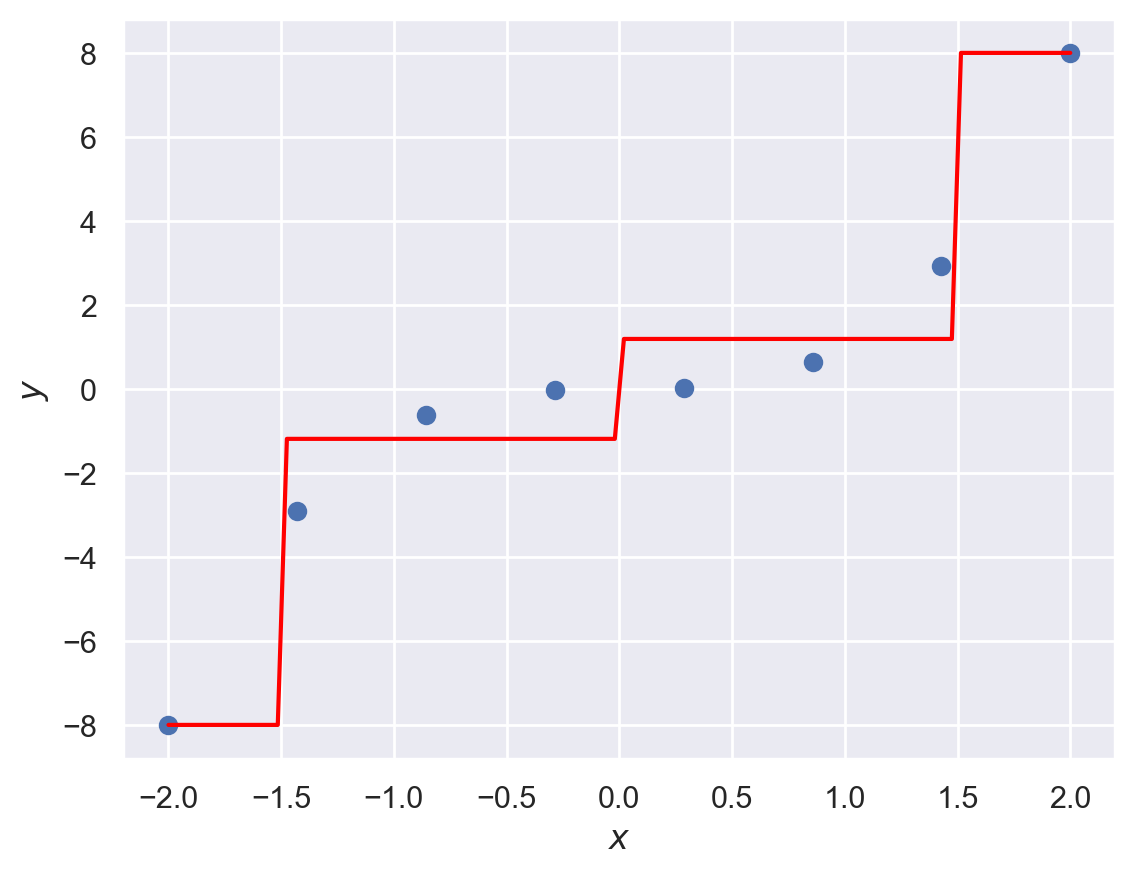

In [55]:
def prediction(x, X, y):
    if x >= 1.5:
        return np.mean(y[X >= 1.5])
    elif x < 1.5 and x >= 0:
        return np.mean(y[(X >= 0) & (X < 1.5)])
    elif x >= -1.5 and x < 0:
        return np.mean(y[(X < 0) & (X >= -1.5)])
    else:
        return np.mean(y[X < -1.5])


predictions = [prediction(x, X, y) for x in xx]


plt.scatter(X, y)
plt.plot(xx, predictions, c="red")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$");

From the plot, the regression tree’s prediction $\hat{y}(x)$ is clearly a **piecewise-constant** (step) function: each leaf returns a single constant value (the mean of the targets in that leaf). Here the tree has **4 leaves**, so on $x \in [-2,2]$ the prediction is made of **4 horizontal segments**, with discontinuities at the split thresholds $x=-1.5$, $x=0$, and $x=1.5$.



<div style="font-size:24px; color:hotpink;"> 

Regression trees predict a **constant value per leaf**, so the overall prediction function is **piecewise-constant**. And with our depth-2 tree we have **4 leaves**, so we get **4 constant “pieces”** over $[-2,2]$.
</div>

## **2. Building a decision tree for predicting heart disease**

Now let’s switch from the toy 1D example to a real classification task: predicting whether a patient has cardiovascular disease (CVD) from basic examination data.

### **Dataset**
We will use the heart disease that you can download it from [here](https://github.com/Yorko/mlcourse.ai/blob/master/data/mlbootcamp5_train.csv) by clicking **Download** and saving the file.

### **Problem**
Given a patient’s measurements and self-reported information, predict the **presence** or **absence** of cardiovascular disease (CVD).

### **Feature types**
The input variables fall into three groups:

- **Objective:** factual patient information  
- **Examination:** results measured during the medical exam  
- **Subjective:** information reported by the patient  

### **Data description**

| Feature | Group | Variable | Value type / encoding |
|---|---|---|---|
| Age | Objective | `age` | int (days) |
| Height | Objective | `height` | int (cm) |
| Weight | Objective | `weight` | float (kg) |
| Gender | Objective | `gender` | categorical code |
| Systolic blood pressure | Examination | `ap_hi` | int |
| Diastolic blood pressure | Examination | `ap_lo` | int |
| Cholesterol | Examination | `cholesterol` | 1 = normal, 2 = above normal, 3 = well above normal |
| Glucose | Examination | `gluc` | 1 = normal, 2 = above normal, 3 = well above normal |
| Smoking | Subjective | `smoke` | binary |
| Alcohol intake | Subjective | `alco` | binary |
| Physical activity | Subjective | `active` | binary |
| Cardiovascular disease | **Target** | `cardio` | binary |

All values were recorded at the time of the medical examination.


In [56]:
df = pd.read_csv(
    "./Data/mlbootcamp5_train.csv", index_col="id", sep=";"
)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [58]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### Feature transformation

Before training the tree, we’ll do a small amount of preprocessing to make the features easier for the model to use.

- **Convert age from days to years.**  
  Create a new feature `age_years` by dividing `age` by $365.25$ and taking the floor:
  $$
  \text{age\_years} = \left\lfloor \frac{\text{age}}{365.25} \right\rfloor,
  $$
  where $\lfloor x \rfloor$ is the greatest integer less than or equal to $x$.

- **One-hot encode cholesterol.**  
  Create three binary (0/1) features indicating whether `cholesterol` equals 1, 2, or 3.

- **One-hot encode glucose.**  
  Similarly, create three binary features indicating whether `gluc` equals 1, 2, or 3.

This is the standard **dummy encoding / One-Hot Encoding (OHE)** approach. In practice, we can do it cleanly using `pandas.get_dummies`.  
After encoding, we can drop the original `cholesterol` and `gluc` columns, since their information is fully captured by the new binary features.


In [59]:
train_df = df.copy()
train_df["age_years"] = (train_df["age"] / 365.25).astype(int)

target = train_df["cardio"]

train_df = pd.get_dummies(
    train_df,
    columns=["cholesterol", "gluc"],
    dtype=int
).drop(columns=["cardio", "age"])  # OHE + drops original columns automatically

train_df.head()


,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,50,1,0,0,1,0,0
1,1,156,85.0,140,90,0,0,1,55,0,0,1,1,0,0
2,1,165,64.0,130,70,0,0,0,51,0,0,1,1,0,0
3,2,169,82.0,150,100,0,0,1,48,1,0,0,1,0,0
4,1,156,56.0,100,60,0,0,0,47,1,0,0,1,0,0


In [60]:
target.value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

Next, we split the dataset into **training** and **holdout** sets using a **70/30** ratio.  
Since the target classes are (almost) perfectly balanced, stratification is not strictly necessary, but we will still use `stratify=target` to preserve class proportions exactly and keep the split robust.  
We use `sklearn.model_selection.train_test_split` with `random_state=17` to make the split reproducible.


In [61]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    train_df, target, test_size=0.3, random_state=17, stratify=target
)


After splitting the data, we train a decision tree classifier on `(X_train, y_train)` with **maximum depth = 3** and `random_state=17`.

To visualize the result, we’ll use `sklearn.tree.export_graphviz`.  
Scikit-learn doesn’t actually *draw* the tree by itself. Instead, `export_graphviz` exports the trained model as a **Graphviz `.dot` description** (in our case, returned as a string via `out_file=None`). We then pass this DOT text to `pydotplus`, which uses Graphviz under the hood to render the tree into a PNG image.


In [62]:
dtree = DecisionTreeClassifier(max_depth=3, random_state=17)
dtree.fit(X_train, y_train)
dtree.classes_

array([0, 1])

`dtree.classes_` shows the class labels the classifier was trained on, **in the exact order the model uses internally** (this order also matches the columns of `predict_proba`).

For our binary target `cardio`, it looks like:

`array([0, 1])`

which means:

- class `0` = **No CVD**
- class `1` = **CVD**


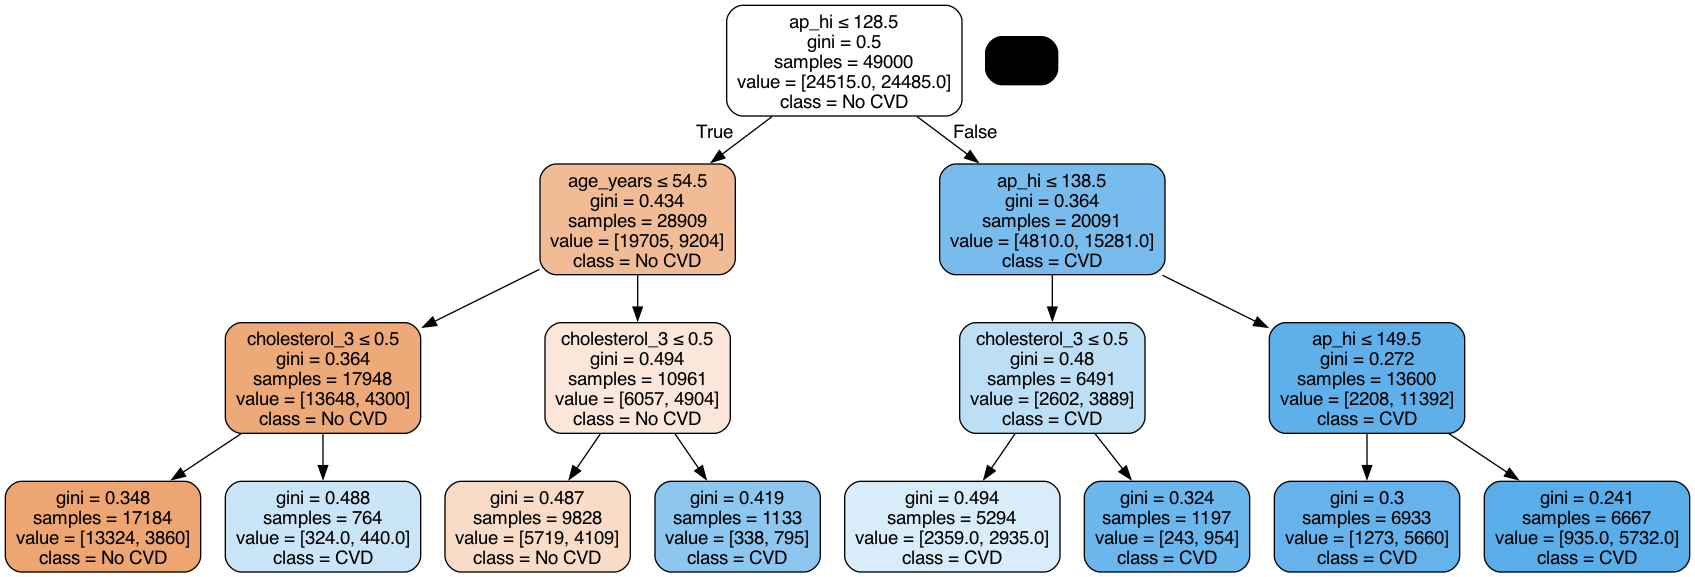

In [63]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

dot = export_graphviz(
    dtree,
    out_file=None,
    feature_names=X_train.columns,
    class_names=["No CVD", "CVD"],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())


Next, we use the trained decision tree to make predictions on the holdout set `(X_holdout, y_holdout)` and evaluate its performance by computing the **accuracy**.


In [64]:
dtree_pred_holdout = dtree.predict(X_holdout)
tree_acc_holdout = accuracy_score(dtree_pred_holdout , y_holdout)
tree_acc_holdout

0.7259523809523809

So far, we picked `max_depth=3` simply because it was a reasonable starting point. But “reasonable” is not a tuning strategy, it’s a guess. To choose the tree depth more systematically (and hopefully improve performance), we’ll tune `max_depth` using cross-validation on `(X_train, y_train)`.

We’ll use **5-fold stratified cross-validation** via `StratifiedKFold` to preserve class proportions in each fold. Then we’ll run `GridSearchCV` with `max_depth` ranging from **2 to 10**, keeping `random_state=17` fixed for the model itself.


In [65]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
tree_params = {"max_depth": range(2, 11)}

tree_grid = GridSearchCV(dtree, tree_params, cv=cv, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,estimator,DecisionTreeC...ndom_state=17)
,param_grid,"{'max_depth': range(2, 11)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


Now that `GridSearchCV` has evaluated each candidate depth, we can examine the results directly. We plot the **mean cross-validated accuracy** as a function of `max_depth` to see how performance changes as the tree grows deeper.


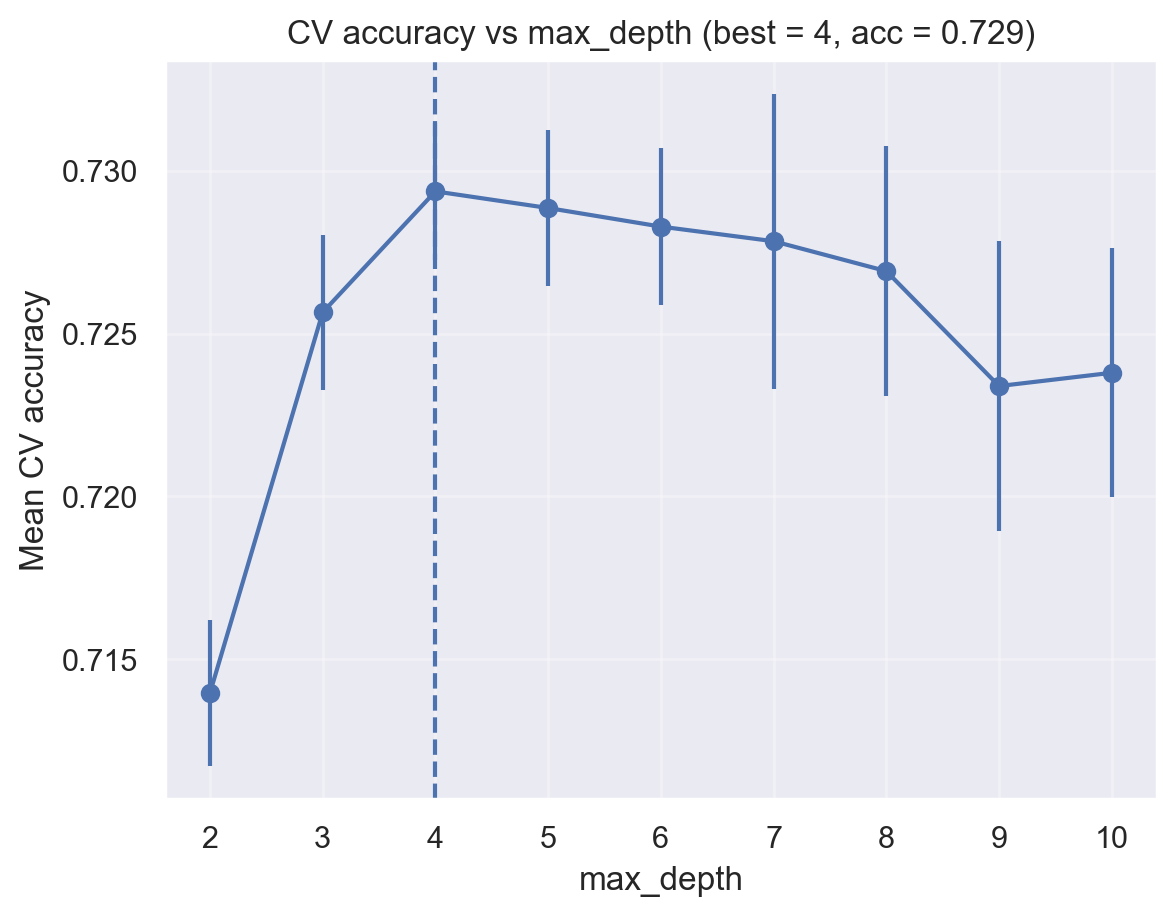

In [66]:
# Collect CV results into a DataFrame
res = pd.DataFrame(tree_grid.cv_results_)

# Extract depth + scores (GridSearchCV stores params as objects, so cast to int)
depths = res["param_max_depth"].astype(int)
mean_acc = res["mean_test_score"]
std_acc = res["std_test_score"]

# Sort by depth (just in case)
order = depths.argsort()
depths = depths.iloc[order]
mean_acc = mean_acc.iloc[order]
std_acc = std_acc.iloc[order]

# Plot (with error bars = std across folds)
plt.errorbar(depths, mean_acc, yerr=std_acc, fmt="o-")
plt.xlabel("max_depth")
plt.ylabel("Mean CV accuracy")
plt.xticks(depths)
plt.grid(True, alpha=0.3)

# Mark the best depth
best_depth = tree_grid.best_params_["max_depth"]
plt.axvline(best_depth, linestyle="--")
plt.title(f"CV accuracy vs max_depth (best = {best_depth}, acc = {tree_grid.best_score_:.3f})")

plt.show()


From the plot, the mean CV accuracy increases quickly from `max_depth=2` to about `max_depth=4`, where it reaches its peak (around $0.729$). After that, deeper trees do not improve cross-validation performance and even show a slight decline, suggesting diminishing returns and mild overfitting.

Next, we identify the **best** value of `max_depth` (the one that maximizes the mean cross-validation accuracy) and evaluate the tuned model on the **holdout** set. Conveniently, `GridSearchCV` already stores the best parameters, the best cross-validation score, and the best trained estimator, so we can extract all of this directly from the fitted `tree_grid` object.


In [67]:
best_tree = tree_grid.best_estimator_
scores = cross_val_score(best_tree, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
print("Best-tree CV mean:", scores.mean(), "Std:", scores.std())
scores 

Best-tree CV mean: 0.7293673469387755 Std: 0.0021104448605379694


array([0.72908163, 0.73010204, 0.72561224, 0.73204082, 0.73      ])

In [68]:
print("Best params:", tree_grid.best_params_)
print("Best cross validaton score", tree_grid.best_score_)

Best params: {'max_depth': 4}
Best cross validaton score 0.7293673469387755


In [69]:
tuned_tree_acc_holdout = accuracy_score(best_tree.predict(X_holdout) , y_holdout)
tuned_tree_acc_holdout

0.729904761904762

Now, let’s quantify the effect of tuning with `GridSearchCV`.  
We compare the holdout accuracy **before** and **after** selecting `max_depth` via cross-validation, and compute the relative improvement:
$$
\frac{\text{acc}_2 - \text{acc}_1}{\text{acc}_1}\cdot 100\%,
$$
where $\text{acc}_1$ is the holdout accuracy of the initial tree (before tuning) and $\text{acc}_2$ is the holdout accuracy of the tuned tree (after `GridSearchCV`).


In [70]:
(tuned_tree_acc_holdout - tree_acc_holdout)/tree_acc_holdout*100

0.5444408002623933

The relative improvement is about $0.54\%$, meaning that tuning `max_depth` with `GridSearchCV` increased the holdout accuracy by **less than 1%**. 


Before we go further, it’s worth remembering that clinicians have been estimating CVD risk long before `GridSearchCV` existed. One well-known example is the **SCORE** table, which provides an estimate of the **10-year risk of fatal cardiovascular disease** in Europe.  
([Source paper](https://academic.oup.com/eurheartj/article/24/11/987/427645))

<img src="./Images/SCORE2007-eng.png" width="70%">

The table suggests a very simple idea: risk is largely driven by a few coarse factors (age band, systolic blood pressure band, cholesterol category, sex, and smoking). So instead of feeding the model all the raw continuous values, we’ll engineer a small set of **binary features** that mimic this scorecard-style logic.

### **Feature engineering inspired by SCORE**

Create binary indicators for the following intervals:

- **Age bands** (4 features):  
  $age \in [40,50)$, $age \in [50,55)$, $age \in [55,60)$, $age \in [60,65)$

- **Systolic blood pressure bands** (3 features):  
  $ap\_hi \in [120,140)$, $ap\_hi \in [140,160)$, $ap\_hi \in [160,180)$

If a patient’s age or blood pressure does not fall into any of these intervals, then all corresponding binary features are set to $0$.

Add the remaining SCORE-style inputs:

- Include `smoke` as-is (already binary).
- One-hot encode `cholesterol` into three binary features for its three unique values:  
  `cholesterol = 1`, `cholesterol = 2`, `cholesterol = 3`.
- Convert `gender` from $\{1,2\}$ into a single binary feature `male` (0 = woman, 1 = man).  
  (You could use `LabelEncoder`, but with only two values it’s overkill.)

In total, we will train a decision tree using **12 engineered binary features** (and drop the original raw features used earlier).

Next, we build a decision tree with `max_depth=3` and `random_state=17`, training it on the **full training dataset** (all other `DecisionTreeClassifier` parameters left as default).



In [71]:
sub_df = pd.DataFrame(df["smoke"].copy())
sub_df["male"] = df["gender"] - 1
df["age_years"] = (df["age"] / 365.25).astype(int)
sub_df["age_40_50"] = ((df["age_years"] >= 40) & (df["age_years"] < 50)).astype(int)
sub_df["age_50_55"] = ((df["age_years"] >= 50) & (df["age_years"] < 55)).astype(int)
sub_df["age_55_60"] = ((df["age_years"] >= 55) & (df["age_years"] < 60)).astype(int)
sub_df["age_60_65"] = ((df["age_years"] >= 60) & (df["age_years"] < 65)).astype(int)

sub_df["ap_hi_120_140"] = ((df["ap_hi"] >= 120) & (df["ap_hi"] < 140)).astype(int)
sub_df["ap_hi_140_160"] = ((df["ap_hi"] >= 140) & (df["ap_hi"] < 160)).astype(int)
sub_df["ap_hi_160_180"] = ((df["ap_hi"] >= 160) & (df["ap_hi"] < 180)).astype(int)

sub_df["chol=1"] = (df["cholesterol"] == 1).astype(int)
sub_df["chol=2"] = (df["cholesterol"] == 2).astype(int)
sub_df["chol=3"] = (df["cholesterol"] == 3).astype(int)

In [72]:
sub_df.head()

,smoke,male,age_40_50,age_50_55,age_55_60,age_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180,chol=1,chol=2,chol=3
id,,,,,,,,,,,,
0,0,1,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,0,1
2,0,0,0,1,0,0,1,0,0,0,0,1
3,0,1,1,0,0,0,0,1,0,1,0,0
4,0,0,1,0,0,0,0,0,0,1,0,0


In [73]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17).fit(sub_df, target)

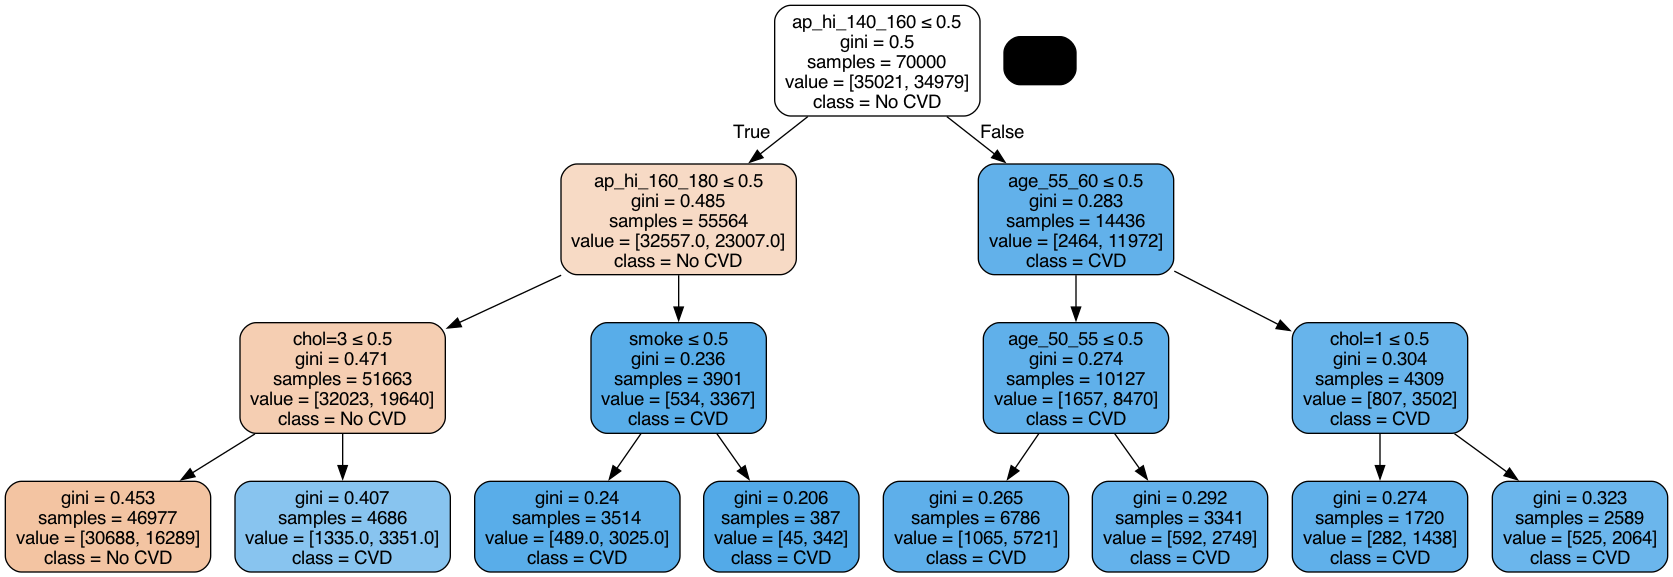

In [74]:
dot = export_graphviz(
    tree,
    out_file=None,
    feature_names=sub_df.columns,
    class_names=["No CVD", "CVD"],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())

From the trained tree we can see that the **root split** is `ap_hi_140_160 ≤ 0.5`, i.e., whether the patient’s systolic blood pressure falls in the **140–160 mmHg** range. Since the root node is the first decision the model makes (and therefore the split that reduces impurity the most), **“Systolic blood pressure from 140 to 160 (mmHg)” is the most important binary feature** in this tree for detecting cardiovascular disease.


At this point, we’ve already taken decision trees for a pretty thorough test drive.

- In **Part 1**, we used a toy 1D regression example to *see the mechanics*: we plotted the split-gain $Q_{\text{1D}}(t)$ and observed that a regression tree produces a **piecewise-constant** prediction function (one constant value per leaf).
- In **Part 2**, we moved to a real cardiovascular dataset: we did basic preprocessing (OHE, train/holdout split), visualized the learned tree, and used cross-validation to pick a better depth — which improved holdout accuracy, but only slightly (less than $1\%$).
- Finally, we engineered a compact set of **SCORE-inspired binary features** and checked which one ends up at the **root** of the tree (i.e., the very first and most influential split).

Rather than squeezing out another fraction of a percent by tuning more hyperparameters, it’s more useful (and honestly more interesting) to understand what the algorithm is doing *under the hood*: how candidate splits are scored, how recursion stops, and what exactly a leaf stores to produce predictions and class probabilities.

In Part 1, for regression trees, we wrote the split gain in terms of the target variance $D(y)$:
$$
Q(X,y,j,t)
= D(y) - \frac{n_l}{n}D(y_l) - \frac{n_r}{n}D(y_r).
$$

In the implementation we’re about to write, we’ll use the same idea in a **unified form**. We’ll denote the node impurity/dispersion by a generic function $F(\cdot)$, because:
- for **classification**, natural choices are *Gini* and *entropy*;
- for **regression**, we can use *variance* (which is exactly the same $D(\cdot)$ as before) or *mean absolute deviation from the median*.

So **our earlier $D(\cdot)$ is just $F(\cdot)$ when `criterion="variance"`**.

## **3. Implementing a Decision Tree from scratch**

**Specification:**
- The class inherits from `sklearn.base.BaseEstimator`.
- The constructor has the following parameters:
  - `max_depth`: maximum depth of the tree ($\infty$ by default);
  - `min_samples_split`: minimum number of samples in a node required to perform a split (2 by default);
  - `criterion`: split criterion (`"gini"` or `"entropy"` for classification; `"variance"` or `"mad_median"` for regression; `"gini"` by default).
- The class implements methods `fit`, `predict`, and `predict_proba`.
- The `fit` method takes a feature matrix $X$ and target vector $y$ (both `numpy.ndarray`) and returns a trained `DecisionTree` instance built on $(X, y)$ according to the constructor parameters.
- The `predict_proba` method takes a feature matrix $X$ and returns a matrix $P$ of size $X.shape[0] \times K$, where $K$ is the number of classes and $p_{ij}$ is the probability that sample $x_i$ belongs to class $j \in \{1,\dots,K\}$.
- The `predict` method takes a feature matrix $X$ and returns a prediction vector:
  - **classification:** if $x_i$ falls into a leaf $L$, predict the most frequent class among training samples in $L$;
  - **regression:** if $x_i$ falls into a leaf $L$, predict the mean target value of training samples in $L$.

### **Split criterion (general form)**

At a node we have a target vector $y$. For a candidate split $[x_j < t]$, we obtain left/right targets $y_l$ and $y_r$ (with sizes $n_l$ and $n_r$, and $n=n_l+n_r$).

The **split gain** can be written as
$$
Q(X, y, j, t) = F(y) \;-\; \frac{n_l}{n}F(y_l) \;-\; \frac{n_r}{n}F(y_r),
$$
where $F(\cdot)$ measures **impurity** (classification) or **dispersion** (regression).  
The tree chooses $(j,t)$ that maximizes $Q(X, y, j, t)$.

#### **Classification criteria**

Let $p_i$ be the fraction of samples of class $i$ in the node (and $K$ be the number of classes).

- `"gini"`:
$$
F(y) = 1 - \sum_{i=1}^K p_i^2.
$$

- `"entropy"`:
$$
F(y) = -\sum_{i=1}^K p_i \log_2(p_i).
$$

#### **Regression criteria**

- `"variance"`:
$$
F(y) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \bar{y})^2,
\qquad
\bar{y}=\frac{1}{n}\sum_{i=1}^{n}y_i.
$$

- `"mad_median"`:
$$
F(y) = \frac{1}{n}\sum_{i=1}^{n}\left|y_i - \mathrm{med}(y)\right|.
$$

Now that we have a unified definition of $Q(X,y,j,t)$, the next step is to implement the basic building blocks: the impurity/dispersion functions $F(\cdot)$ for all supported criteria (`"gini"`, `"entropy"`, `"variance"`, `"mad_median"`).  
We’ll store them in a dictionary so the tree can select the right function by name (via the `criterion` parameter).


In [75]:
# Let's define quality criterion:

# entropy and Gini criteria are used for classification
def entropy(y):
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return -np.dot(p, np.log2(p))


def gini(y):
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return 1 - np.dot(p, p)


# variance and median criteria are used for regression
def variance(y):
    return np.var(y)


def mad_median(y):
    return np.mean(np.abs(y - np.median(y)))


criteria_dict = {
    "entropy": entropy,
    "gini": gini,
    "variance": variance,
    "mad_median": mad_median,
}

Next, we need a way to *store* the tree we build.  
We’ll represent the model as a set of connected **nodes**: each internal node remembers **which feature** to test and **which threshold** to compare against, while each leaf stores the labels/targets of the training samples that reached it (so we can later convert them into a prediction).

The lightweight `Node` class below is just a container for this information.


In [76]:
class Node:
    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

<details>
<summary><span style="color:red">about this cell:</span></summary>  

This code defines a **`Node` class** — a building block for a **decision tree** (or any binary tree). Each `Node` object represents **one point in the tree**, either:

* a **split node** (it splits data into left/right), or
* a **leaf node** (it stores the final prediction/class distribution).


### `class Node:`

We’re defining a new data type called `Node`.


## ✅ The constructor: `__init__`

This runs whenever we create a node:

```python
node = Node(...)
```

It sets up the node’s internal data.


## ✅ Meaning of each attribute

### 1) `feature_idx`

```python
self.feature_idx = feature_idx
```

* This is the index of the feature used for splitting.
* Example: if `feature_idx = 3`, it means:
  **split on the 4th column of X** (since Python is 0-indexed)


### 2) `threshold`

```python
self.threshold = threshold
```

* This is the split value.
* It defines the rule:

✅ **if X[feature_idx] <= threshold → go left**
✅ **else → go right**

Example: `feature_idx=2`, `threshold=5.7` means:

* if feature 2 ≤ 5.7 → left
* otherwise → right


### 3) `labels`

```python
self.labels = labels
```

This is typically used for a **leaf node** (end of branch), and it represents the prediction information.

Depending on how our tree is designed, `labels` could store:

* the predicted class (e.g., `0` or `1`)
* the class counts (e.g., `{0: 25, 1: 10}`)
* probabilities
* or the actual y-values in that leaf

For a leaf node, we might have:

```python
Node(labels=1)
```

Meaning: predict class `1`.

For an internal node, `labels` is often `None`.


### 4) `left` and `right`

```python
self.left = left
self.right = right
```

These are pointers to the child nodes.

* `left` holds the subtree for values **≤ threshold**
* `right` holds the subtree for values **> threshold**

Example:

```python
root = Node(feature_idx=1, threshold=10)
root.left = Node(labels=0)
root.right = Node(labels=1)
```

This creates a simple tree:

```
if X[1] <= 10:
    predict 0
else:
    predict 1
```


## ✅ Summary

This `Node` class represents a decision tree node that stores:

* **what feature to split on**
* **what threshold to split at**
* **leaf prediction info (labels)**
* and references to **left and right children**.

</details>

We also need to define what a **leaf should output** once a sample reaches it:

- for **regression**, a leaf predicts the **mean** of the target values in that leaf;
- for **classification**, a leaf predicts the **majority class** among the labels in that leaf.

In [77]:
def regression_leaf(y):
    return np.mean(y)


def classification_leaf(y):
    return np.bincount(y).argmax()

<details>
<summary><span style="color:red">about <code>np.bincount(y).argmax()</code>:</span></summary>  

`np.bincount(y).argmax()` is a very common way to get the **most frequent class label** in `y` (i.e., the **mode**) when the labels are non-negative integers.

### 1) `np.bincount(y)`

`np.bincount` counts how many times each integer appears in `y`.

Example:

```python
y = np.array([1, 0, 1, 1, 2]) # y could also be a pandas Series
np.bincount(y)
```

Output:

```python
array([1, 3, 1])
```

Meaning:

* class `0` appears **1** time
* class `1` appears **3** times
* class `2` appears **1** time

So `np.bincount(y)` returns an array where:

* index = class label
* value = count of that label


### 2) `.argmax()`

`.argmax()` returns the **index of the largest value** in the array.

Continuing the example:

```python
np.bincount(y).argmax()
```

`np.bincount(y)` is `[1, 3, 1]`
The biggest count is `3`, which is at index `1` → so result is:

```python
1
```

That means the most common class in `y` is **1**.

### Summary:  

`np.bincount(y).argmax()` counts how often each class appears in `y` and returns the class with the highest count (the majority class).

</details>

Now we can finally assemble the tree itself by implementing the `DecisionTree` class.

The overall idea is straightforward:

1. **Training (`fit`) builds the tree recursively.**  
   At each node we search over candidate splits $(j,t)$, compute the split gain  
   $$Q(X,y,j,t)=F(y)-\frac{n_l}{n}F(y_l)-\frac{n_r}{n}F(y_r),$$
   choose the best split, and then recurse into the left/right children.  
   We stop growing the tree when we hit a stopping rule (maximum depth, too few samples to split, or a *pure* node where all targets are identical).

2. **Prediction (`predict`) is just tree traversal.**  
   For a new point $x$, we start at the root, repeatedly apply the feature–threshold test ($x_j < t$) to go left or right, and once we reach a leaf we output its stored prediction:
   - **classification:** the most frequent class in that leaf;
   - **regression:** the mean target value in that leaf.

3. **Probabilities (`predict_proba`) (classification only)** come from the leaf as well.  
   Once $x$ lands in a leaf, we return the class proportions among the training samples stored in that leaf (i.e., empirical frequencies).


In [78]:
from sklearn.base import BaseEstimator

class DecisionTree(BaseEstimator):
    def __init__(
        self, max_depth=np.inf, min_samples_split=2, criterion="gini", debug=False,
    ):
        # Set parameters for the decision tree
        params = {
            "max_depth": max_depth,              # Maximum depth of the tree
            "min_samples_split": min_samples_split,  # Minimum samples to split a node
            "criterion": criterion,              # Criterion for measuring the quality of a split
            "debug": debug,                      # Debugging flag for printing intermediate steps
        }

        # Assign parameters to the class instance
        for param_name, param_value in params.items():
            setattr(self, param_name, param_value)

        # Call BaseEstimator's set_params method (from scikit-learn) to set the parameters
        super(DecisionTree, self).set_params(**params)

        # Set the criterion function based on the chosen criterion
        self._criterion_function = criteria_dict[criterion]

        # Set the leaf value function depending on the criterion (for regression or classification)
        if criterion in ["variance", "mad_median"]:
            self._leaf_value = regression_leaf
        else:
            self._leaf_value = classification_leaf

        # If debugging is enabled, print out the parameters of the decision tree
        if self.debug:
            print(f"\nDecisionTree params:\n{params}")

    # Functional for splitting the data by feature index and threshold
    def _functional(self, X, y, feature_idx, threshold):
        mask = X[:, feature_idx] < threshold  # Create a mask for data points less than the threshold
        n_obj = X.shape[0]  # Total number of samples
        n_left = np.sum(mask)  # Number of samples in the left split
        n_right = n_obj - n_left  # Number of samples in the right split
        
        # If both splits contain data, calculate the split gain (impurity reduction)
        if n_left > 0 and n_right > 0:
            return (
                self._criterion_function(y)  # Impurity before the split
                - (n_left / n_obj) * self._criterion_function(y[mask])  # Impurity for the left split
                - (n_right / n_obj) * self._criterion_function(y[~mask])  # Impurity for the right split
            )
        else:
            return 0  # No gain if the split is not possible

    # Recursive procedure for building the decision tree
    def _build_tree(self, X, y, depth=1):
        max_functional = 0
        best_feature_idx = None
        best_threshold = None
        n_samples, n_features = X.shape

        # If all samples in the node have the same target, no split is needed
        if len(np.unique(y)) == 1:
            return Node(labels=y)

        # If depth or sample size limits are not reached, proceed to find the best split
        if depth < self.max_depth and n_samples >= self.min_samples_split:
            if self.debug:
                print(f"depth = {depth}, n_samples = {n_samples}")

            # Iterate over all features
            for feature_idx in range(n_features):
                # Get all unique threshold values for the current feature
                threshold_values = np.unique(X[:, feature_idx])
                functional_values = [
                    self._functional(X, y, feature_idx, threshold)  # Compute the functional (split gain)
                    for threshold in threshold_values
                ]

                # Find the threshold that gives the best split
                best_threshold_idx = np.nanargmax(functional_values)

                # If the current split is better than the previous best, update the best split
                if functional_values[best_threshold_idx] > max_functional:
                    max_functional = functional_values[best_threshold_idx]
                    best_threshold = threshold_values[best_threshold_idx]
                    best_feature_idx = feature_idx
                    best_mask = X[:, feature_idx] < best_threshold  # Mask for left split

        # If we found a good split, recursively build the left and right children
        if best_feature_idx is not None:
            if self.debug:
                print(f"best feature = {best_feature_idx}, best threshold = {best_threshold}")
            return Node(
                feature_idx=best_feature_idx,
                threshold=best_threshold,
                left=self._build_tree(X[best_mask, :], y[best_mask], depth + 1),
                right=self._build_tree(X[~best_mask, :], y[~best_mask], depth + 1),
            )
        else:
            # If no split is found, create a leaf node
            return Node(labels=y)

    # Fit the decision tree to the training data
    def fit(self, X, y):
        # In classification task, memorize the number of classes
        if self.criterion in ["gini", "entropy"]:
            self._n_classes = len(np.unique(y))

        # Build the tree by recursively calling the _build_tree method
        self.root = self._build_tree(X, y)

        return self

    # Predict the output for a single sample
    def _predict_object(self, x, node=None):
        node = self.root  # Start at the root
        # Traverse the tree until reaching a leaf
        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left  # Go to the left child
            else:
                node = node.right  # Go to the right child
        # Return the leaf value (prediction)
        return self._leaf_value(node.labels)

    # Predict the outputs for a set of samples
    def predict(self, X):
        return np.array([self._predict_object(x) for x in X])

    # Predict the class probabilities for a single sample (for classification)
    def _predict_proba_object(self, x, node=None):
        node = self.root  # Start at the root
        # Traverse the tree until reaching a leaf
        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left  # Go to the left child
            else:
                node = node.right  # Go to the right child
        # Compute the probabilities of each class in the leaf
        return [
            len(node.labels[node.labels == k]) / len(node.labels)  # Probability of class k
            for k in range(self._n_classes)
        ]

    # Predict the class probabilities for a set of samples
    def predict_proba(self, X):
        return np.array([self._predict_proba_object(x) for x in X])


<details>
<summary><span style="color:red">about this cell:</span></summary>  

This is a **from-scratch implementation of a Decision Tree**, written in a way that’s compatible with scikit-learn (because it inherits from `BaseEstimator`). It supports **classification** (Gini/Entropy) and **regression** (Variance/MAD median), and builds a **binary tree** using recursion.


# 1) Class definition + constructor (`__init__`)

```python
class DecisionTree(BaseEstimator):
    def __init__(self, max_depth=np.inf, min_samples_split=2, criterion="gini", debug=False):
```

This defines a DecisionTree model with hyperparameters:

* **max_depth**: maximum depth of the tree (how many splits from root to leaf)
* **min_samples_split**: minimum number of samples required in a node to try splitting further
* **criterion**: how to measure split quality

  * `"gini"` or `"entropy"` → classification
  * `"variance"` or `"mad_median"` → regression
* **debug**: print extra information while building the tree

> **BaseEstimator** is a helper base class from `sklearn.base` that provides the standard behavior expected from *scikit-learn-style* models. Practically, it gives us `get_params()` and `set_params()`, which are essential for tools like `GridSearchCV`, pipelines, cloning, and more.

### Setting parameters

```python
params = {...}
for param_name, param_value in params.items():
    setattr(self, param_name, param_value)
super(DecisionTree, self).set_params(**params)
```

* `setattr(self, "max_depth", max_depth)` dynamically assigns attributes.
* `set_params` makes the model compatible with sklearn tools like `GridSearchCV`.

### Choosing the split criterion function

```python
self._criterion_function = criteria_dict[criterion]
```

Earlier we defined athis dictionary:

```python
criteria_dict = {
    "gini": gini_function,
    "entropy": entropy_function,
    ...
}
```

So depending on the criterion, the tree uses a different impurity/loss function.

### Choosing how to compute a leaf prediction

```python
if criterion in ["variance", "mad_median"]:
    self._leaf_value = regression_leaf
else:
    self._leaf_value = classification_leaf
```

* **For regression criteria** (`"variance"`, `"mad_median"`), the model uses `regression_leaf` function, which returns the **mean of the target values** that reached the leaf:

  ```python
  regression_leaf(y) = np.mean(y)
  ```

  So each leaf predicts a **continuous number** (the average of the training targets in that leaf).

* **For classification criteria** (`"gini"`, `"entropy"`), the model uses `classification_leaf` function, which returns the **most frequent class label** among the samples in the leaf:

  ```python
  classification_leaf(y) = np.bincount(y).argmax()
  ```

  So each leaf predicts the **majority class** (a discrete label).

* Regression → **predict the mean value**
* Classification → **predict the majority class**

Note:  

The underscore (`_`) at the start of a method name in Python is a **naming convention** that means:

> **“This is intended for internal use only (private-ish).”**

So methods like:

```python
_functional()
_build_tree()
_predict_object()
_predict_proba_object()
```

are meant to be **helper methods** used *inside the class*, not part of the public API that users should call directly.


# 2) `_functional(...)`: how good is a split?

```python
def _functional(self, X, y, feature_idx, threshold):
    mask = X[:, feature_idx] < threshold
    ...
```

This computes the **information gain / impurity reduction** from splitting on:

* `feature_idx` (which feature) (This is the index of the feature used for splitting)
* `threshold` (split value)

### Steps:

1. Create `mask` telling which rows go left:

   ```python
   mask = X[:, feature_idx] < threshold
   ```
2. Count samples going left/right:

   ```python
   n_left = np.sum(mask)
   n_right = n_obj - n_left
   ```
3. If both sides have at least one sample:

   ```python
   parent_impurity
   - weighted(left_impurity)
   - weighted(right_impurity)
   ```

   which is:

   ```python
   self._criterion_function(y)
   - (n_left/n_obj) * self._criterion_function(y[mask])
   - (n_right/n_obj) * self._criterion_function(y[~mask])
   ```

This is exactly the **standard split quality measure**:

* For classification: reduction in impurity (Gini or entropy)
* For regression: reduction in dispersion (variance or MAD median)

If the split puts everything on one side, it returns `0` because that split is useless.


# 3) `_build_tree(...)`: recursively construct the tree

```python
def _build_tree(self, X, y, depth=1):
```

This is the heart of the algorithm.

### Step A — Base case: all labels are the same

```python
if len(np.unique(y)) == 1:
    return Node(labels=y)
```

If all targets are identical, no point splitting further → make a **leaf node**.

> Note: It stores `labels=y` (all y values reaching leaf), and later uses `_leaf_value(labels)` to compute final prediction.


### Step B — Try to find the best split (if stop conditions allow)

```python
if depth < self.max_depth and n_samples >= self.min_samples_split:
```

Only split if:

* depth isn’t too big
* node has enough samples

Then for **each feature**:

```python
for feature_idx in range(n_features):
```

For each **possible threshold** (unique feature values):

```python
threshold_values = np.unique(X[:, feature_idx])
```

Compute split scores for every threshold:

```python
functional_values = [
    self._functional(X, y, feature_idx, threshold)
    for threshold in threshold_values
] # self._functional(...) computes the split quality score (impurity/variance reduction)
```

Find the best threshold for that feature:

```python
best_threshold_idx = np.nanargmax(functional_values) 
# It means: Find the index of the threshold that gives the highest split quality score, ignoring any NaN values.
```

Then compare it to the best split found so far across all features:

```python
if functional_values[best_threshold_idx] > max_functional:
    ...
```

If it’s better → save:

* best feature
* best threshold
* mask describing left/right split


### Step C — Build left and right subtrees (recursively)

If a good split was found:

```python
return Node(
    feature_idx=best_feature_idx,
    threshold=best_threshold,
    left=self._build_tree(...),
    right=self._build_tree(...),
)
```

So each internal node stores:

* feature index
* threshold
* pointers to left and right child nodes

If *no split was found* (e.g. all gains were 0):

```python
return Node(labels=y)
```

So it becomes a leaf.


# 4) `fit(X, y)`: build the tree

```python
def fit(self, X, y):
```

If doing classification:

```python
if self.criterion in ["gini", "entropy"]:
    self._n_classes = len(np.unique(y))
```

This stores how many classes exist for probability prediction later.

Build the tree:

```python
self.root = self._build_tree(X, y)
```

Return self → sklearn style.

**1) Why do we write: `node = self.root`?**  

When you call `.fit(X, y)`, the code builds the whole tree and stores it here:

```python
self.root = self._build_tree(X, y)
```

So:

* `self.root` is the **top node of the tree** (the starting point).
* Every other node is connected through `.left` and `.right`.

During prediction for one sample `x`, we start from the top:

```python
node = self.root
```

This is like saying:

> “Start at the root of the tree, and then move down.”

Why assign it to `node`?
Because we are going to update `node` as we move down:

```python
node = node.left
node = node.right
```

If you used `self.root` directly, you’d overwrite the root or make code awkward. So `node` is just a **temporary pointer** that walks through the tree.

# 5) Predicting one object (`_predict_object`)

```python
while node.labels is None:
    if x[node.feature_idx] < node.threshold:
        node = node.left
    else:
        node = node.right
return self._leaf_value(node.labels)
```

This traverses the tree:

* start at the root
* go left or right depending on feature value
* stop when you reach a leaf (`node.labels != None`)
* compute prediction from leaf labels:

  * classification leaf = majority class
  * regression leaf = mean/median


**What is `node.labels` and why this loop?** 

Reminder: what a Node looks like 

A node can be either:

**✅ Internal (decision) node**  

It contains:

* `feature_idx`
* `threshold`
* `left`, `right`
* and importantly: **`labels = None`**

So:

```python
node.labels is None
```

means:

> “This is NOT a leaf. Keep splitting.”

**✅ Leaf node**  

It has:

* `labels = y` (the training labels that ended up in that leaf)
* and it usually does **not need** feature_idx/threshold

So:

```python
node.labels is NOT None
```

means:

> “This is a leaf. Stop here.”


**So what does this loop mean?** 

```python
while node.labels is None:
```

This means:

> “Keep going down the tree as long as you are at a decision node.”

Then for each decision node, decide whether the sample goes left or right:

```python
if x[node.feature_idx] < node.threshold:
    node = node.left
else:
    node = node.right
```

Eventually, you reach a leaf node where:

```python
node.labels is not None
```

Then you stop and predict using the leaf labels:

```python
return self._leaf_value(node.labels)
```

For classification, `_leaf_value` returns the majority class.
For regression, it returns the mean.


# 6) Predicting many objects (`predict`)

```python
return np.array([self._predict_object(x) for x in X])
```

Just calls the single-object prediction for each row of X.


# 7) Predict probabilities (`predict_proba`)

The `_predict_proba_object` function does the same traversal but returns class probabilities:

```python
return [
    len(node.labels[node.labels == k]) / len(node.labels)
    for k in range(self._n_classes)
]
```

So if a leaf contains:

```python
node.labels = [0,0,0,1]
```

Then probabilities are:

* P(class 0) = 3/4
* P(class 1) = 1/4

And `predict_proba(X)` applies that to every sample.


# limitations of this implementation

This is a good educational implementation, but compared to sklearn’s `DecisionTreeClassifier`, it’s slower because:

1. It tries thresholds using **every unique value** → expensive.
2. Uses `< threshold` instead of `<= threshold` (not wrong, just a choice).
3. Leaf stores **all labels** (can cost memory for large trees).
4. No handling of missing values.
5. No feature subsampling / pruning / cost-complexity pruning.


# Summary

This class builds a binary decision tree by recursively searching over every feature and every possible threshold, scoring each split by how much it reduces impurity (Gini/Entropy/Variance/etc.). It stops splitting when it reaches maximum depth, too few samples, or pure nodes. Leaves store the labels of training samples that end there, and predictions are computed at leaves using majority class (classification) or a regression rule. The resulting tree is traversed for prediction.

</details>


<details>
<summary><span style="color:red">a bit more precisely:</span></summary>  


```python
params = {...}
for param_name, param_value in params.items():
    setattr(self, param_name, param_value)
super(DecisionTree, self).set_params(**params)
```

This block is doing **two related things**:

1. it stores the model hyperparameters as attributes of the object
2. it registers those hyperparameters in a way that makes the estimator work nicely with scikit-learn tools (`GridSearchCV`, `clone`, pipelines, etc.)

## 1) `params = {...}`

This is just a dictionary holding the parameters passed into `__init__`, like:

```python
params = {
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "criterion": criterion,
    "debug": debug,
}
```

So it’s collecting all init arguments in one place.


## 2) The loop with `setattr`

```python
for param_name, param_value in params.items():
    setattr(self, param_name, param_value)
```

### What does `setattr` do?

`setattr(object, "attribute_name", value)` is the same as writing:

```python
self.max_depth = max_depth
self.min_samples_split = min_samples_split
self.criterion = criterion
self.debug = debug
```

But instead of writing each line manually, the loop does it dynamically.

✅ After the loop, the object has attributes like:

* `self.max_depth`
* `self.min_samples_split`
* `self.criterion`
* `self.debug`


## 3) `super(...).set_params(**params)`

```python
super(DecisionTree, self).set_params(**params)
```

This calls `set_params()` from `BaseEstimator` (the parent class).

```python
set_params(**params)
```
is exactly the same as writing:

```python
Copy code
set_params(
    max_depth=5,
    min_samples_split=2,
    criterion="gini",
    debug=False
)
```
So **params converts the dictionary key/value pairs into named keyword arguments.


### What does `set_params()` do?

It sets parameters in a standardized scikit-learn way and returns `self`.
It also makes sure the estimator behaves properly with:

* `GridSearchCV` (which calls `.set_params()` repeatedly)
* `clone()` (used in CV and grid search)
* `Pipeline`
* `get_params()`

So this line is basically saying:

> “Tell scikit-learn: these are my parameters, and set them officially.”

### Why do both `setattr` AND `set_params`?

Technically, **you don’t need both** in most sklearn-style classes.

Normally, in sklearn you just do:

```python
self.max_depth = max_depth
self.min_samples_split = min_samples_split
...
```

and BaseEstimator can handle `get_params()` automatically.

But here we wrote both:

* `setattr` → ensures the attributes exist
* `set_params(**params)` → ensures the sklearn parameter system sees them properly

So it’s a bit redundant, but it doesn’t hurt.


## Summary

This code dynamically assigns hyperparameters to the object’s attributes (`self.max_depth`, etc.) and then registers them using scikit-learn’s standard `set_params()` mechanism so the estimator works with tools like `GridSearchCV` and pipelines.

</details>

## **Testing the Custom Model**

### **1) Classification**

Now that we’ve implemented the decision tree from scratch, let’s put it to the test using synthetic data. We’ll focus on verifying that the `predict_proba` method works correctly alongside the `predict` method.

We’ll generate a synthetic classification dataset with two features and 400 samples. After splitting the dataset into training and testing sets, we’ll train our custom `DecisionTree` on the training data, evaluate the model on the test set, and check the accuracy.

Furthermore, we'll validate that the `predict_proba` method returns the correct probabilities by comparing the predicted class labels from `predict_proba` with the labels from `predict`.

Let’s run the code and check how the model performs.


Accuracy: 0.85
predict_proba works!


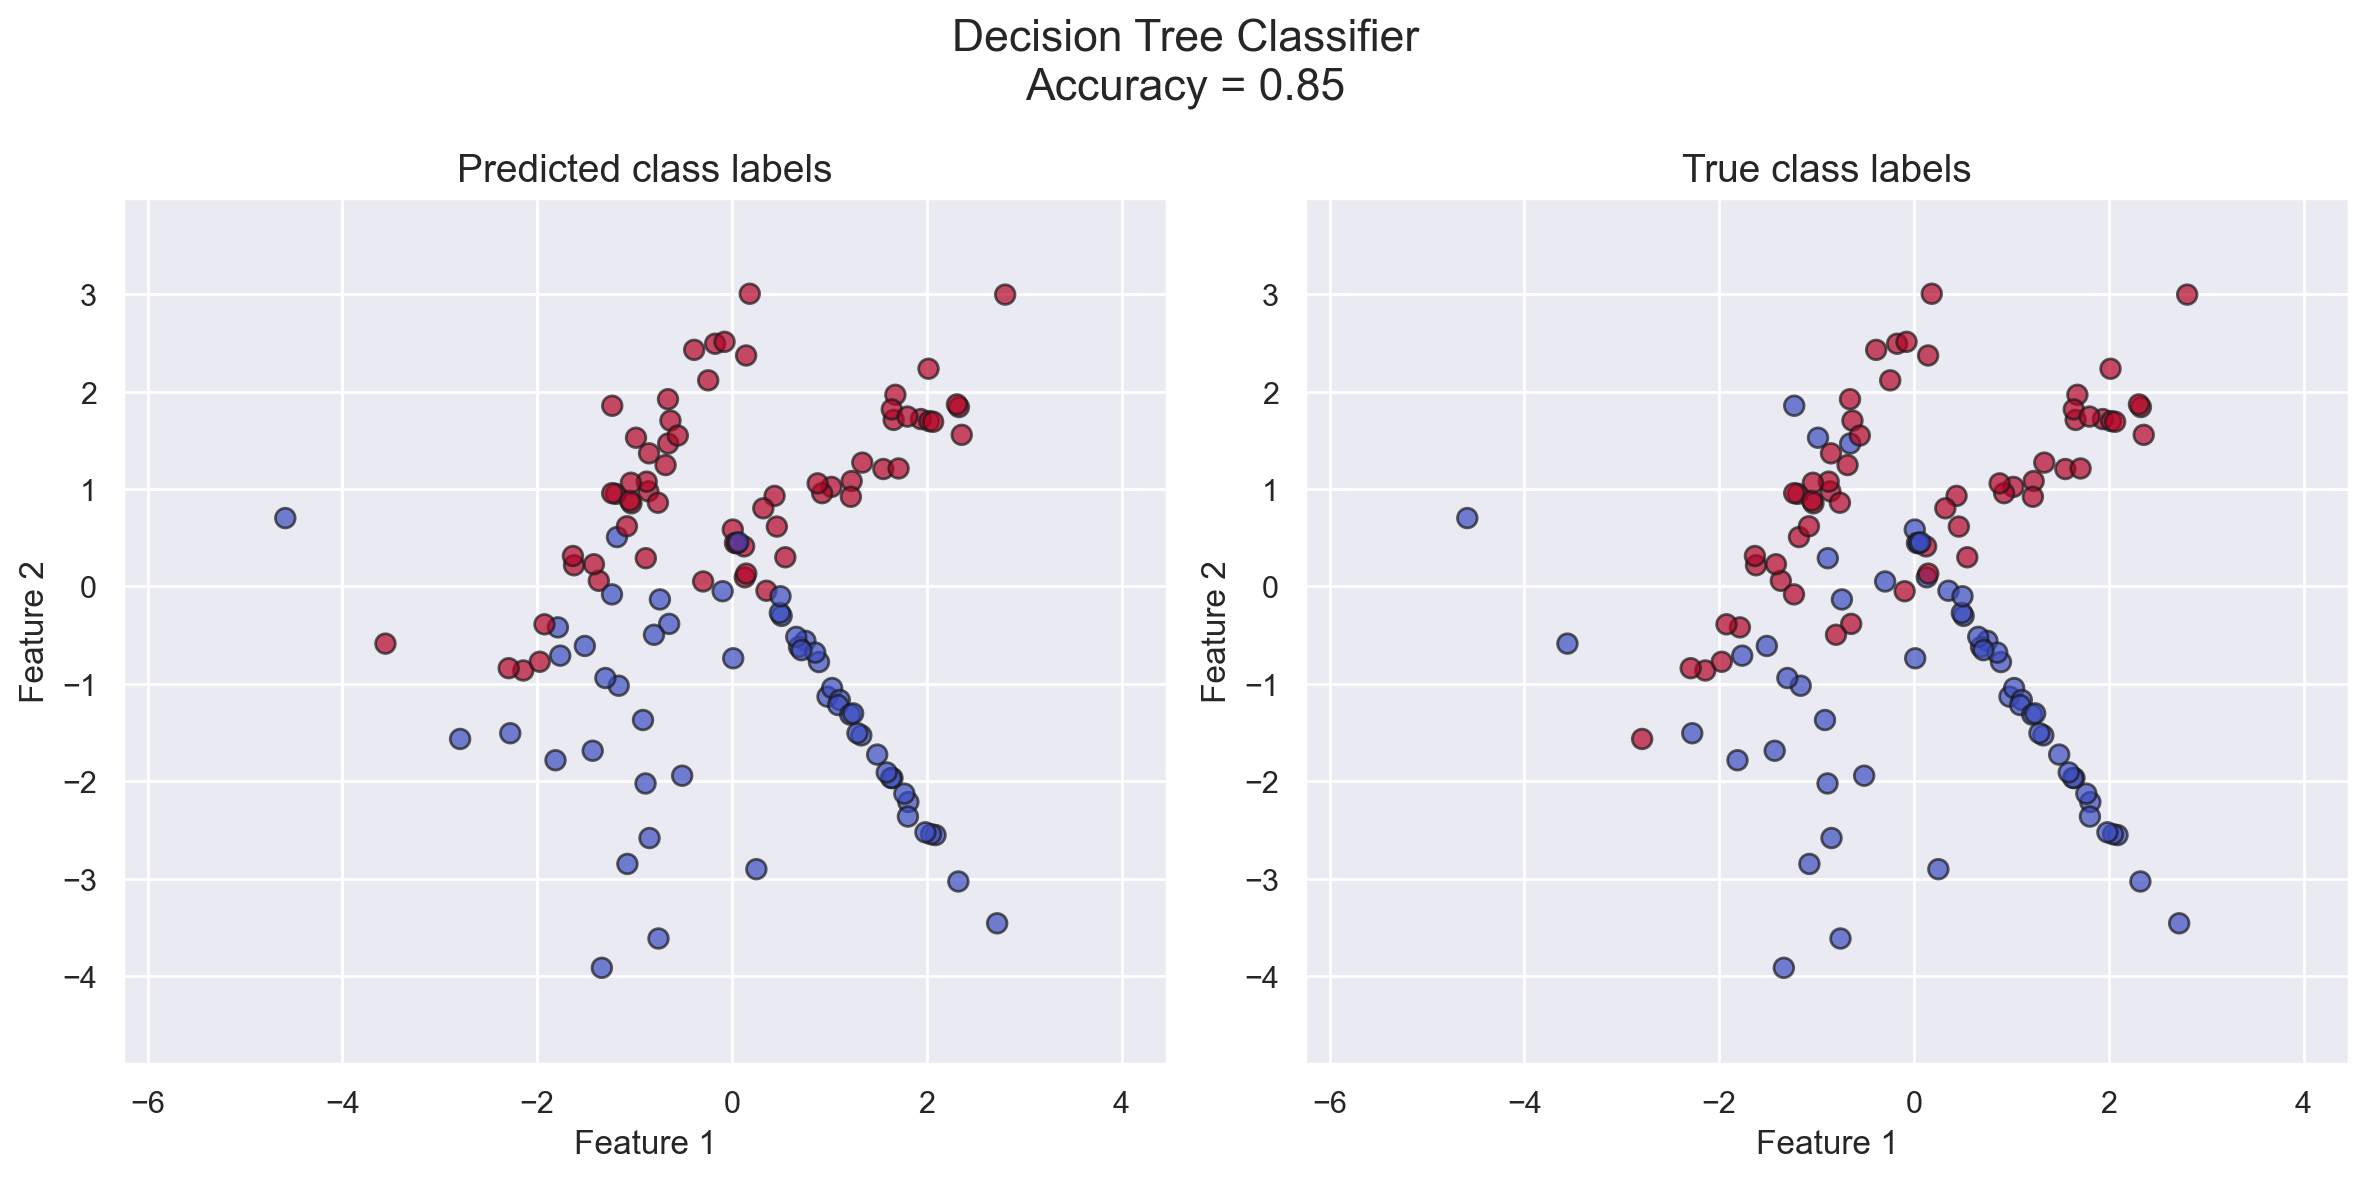

In [79]:
from sklearn.datasets import make_classification

# Setting the random state
RANDOM_STATE = 17

# Generate synthetic classification dataset
X, y = make_classification(
    n_features=2, n_redundant=0, n_samples=400, random_state=RANDOM_STATE
)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

# Initialize and train the custom DecisionTree classifier
clf = DecisionTree(max_depth=4, criterion="gini")
clf.fit(X_train, y_train)

# Make predictions using the trained model
y_pred = clf.predict(X_test)
prob_pred = clf.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy and check if predict_proba works correctly
print("Accuracy:", accuracy)

# Validate the correctness of the predict_proba method
if sum(np.argmax(prob_pred, axis=1) - y_pred) == 0:
    print("predict_proba works!")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.suptitle("Decision Tree Classifier\nAccuracy = {:.2f}".format(accuracy), fontsize=16)

# Plot predicted class labels
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.coolwarm, edgecolor='k', s=50, alpha=0.7)
plt.title("Predicted class labels", fontsize=14)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.axis("equal")

# Plot true class labels
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolor='k', s=50, alpha=0.7)
plt.title("True class labels", fontsize=14)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.axis("equal")

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


After running the code, we can conclude that our custom `DecisionTree` classifier is working well. The accuracy of **0.95** on the synthetic dataset shows that the model is correctly learning and making predictions. The plot on the left shows the predicted class labels, and the one on the right shows the true class labels. The alignment between the predicted and true labels indicates that the decision tree is performing well on this task.

The `predict_proba` function also works as expected, which is confirmed by the comparison of predicted probabilities with the predicted class labels. Overall, the model is making accurate predictions and classifying the data correctly, demonstrating that our implementation of the decision tree algorithm is functioning as intended.

You can also fiddle with the `RANDOM_STATE` parameter and set it to different numbers to observe how the performance of our custom decision tree changes. This will allow you to see the variability in results depending on the random seed used for data splitting, offering insight into how sensitive the model might be to different train-test splits.


Now, let's take a step further and experiment with the famous `digits` dataset. We will train two shallow decision trees on this dataset using different criteria — **Gini** and **Entropy** — and compare their performance to see how the choice of criterion affects the tree's behavior.

Here’s what we’ll do next:

1. Download the `digits` dataset using the method `load_digits`.
2. Split the data into training and test sets with a test size of 20% using `train_test_split`.
3. Train two shallow decision trees (with `max_depth=2`), one using the **Gini** criterion and the other using the **Entropy** criterion.
4. Check if we get different results for these two trees, indicating the influence of the criterion on the model's decision-making process.

Let’s proceed with the implementation and see how the models perform:


In [80]:
from sklearn.datasets import load_digits

# Load the digits dataset
digits = load_digits()

X = digits.data
y = digits.target

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Train Decision Tree with Gini criterion
clf1 = DecisionTree(max_depth=2, criterion="gini", debug=True)
clf1.fit(X_train, y_train)

# Print the accuracy for Gini criterion
print(accuracy_score(clf1.predict(X_test), y_test))

# Train Decision Tree with Entropy criterion
clf2 = DecisionTree(max_depth=2, criterion="entropy", debug=True)
clf2.fit(X_train, y_train)

# Print the accuracy for Entropy criterion
print(accuracy_score(clf2.predict(X_test), y_test))


DecisionTree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'gini', 'debug': True}
depth = 1, n_samples = 1437
best feature = 36, best threshold = 1.0
0.18888888888888888

DecisionTree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'entropy', 'debug': True}
depth = 1, n_samples = 1437
best feature = 21, best threshold = 2.0
0.175


From this quick sanity check with a **very shallow** tree ($\text{max\_depth}=2$), both criteria perform poorly on the `digits` dataset which is exactly what we should expect. With only one split at the root and one more split below it, the tree is simply too simple to capture the structure of handwritten digits.

That said, the two criteria *do* lead to **different first splits** (different feature indices and thresholds), and we also see a small difference in test accuracy:

- `gini`: $0.189$
- `entropy`: $0.175$

So even with the same depth, the choice of impurity measure can push the tree toward different decisions.

Now let’s make the comparison more fair and more informative: instead of mixing `criterion` and `max_depth` in one big grid, we’ll run **two separate grid searches**, one where the criterion is fixed to `"gini"`, and one where it’s fixed to `"entropy"`.  

This way, we can directly compare how accuracy changes with tree depth for each criterion, and plot both curves on the same graph.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
GINI: best max_depth = 10, best CV acc = 0.8476
Fitting 5 folds for each of 9 candidates, totalling 45 fits
ENTROPY: best max_depth = 10, best CV acc = 0.8524


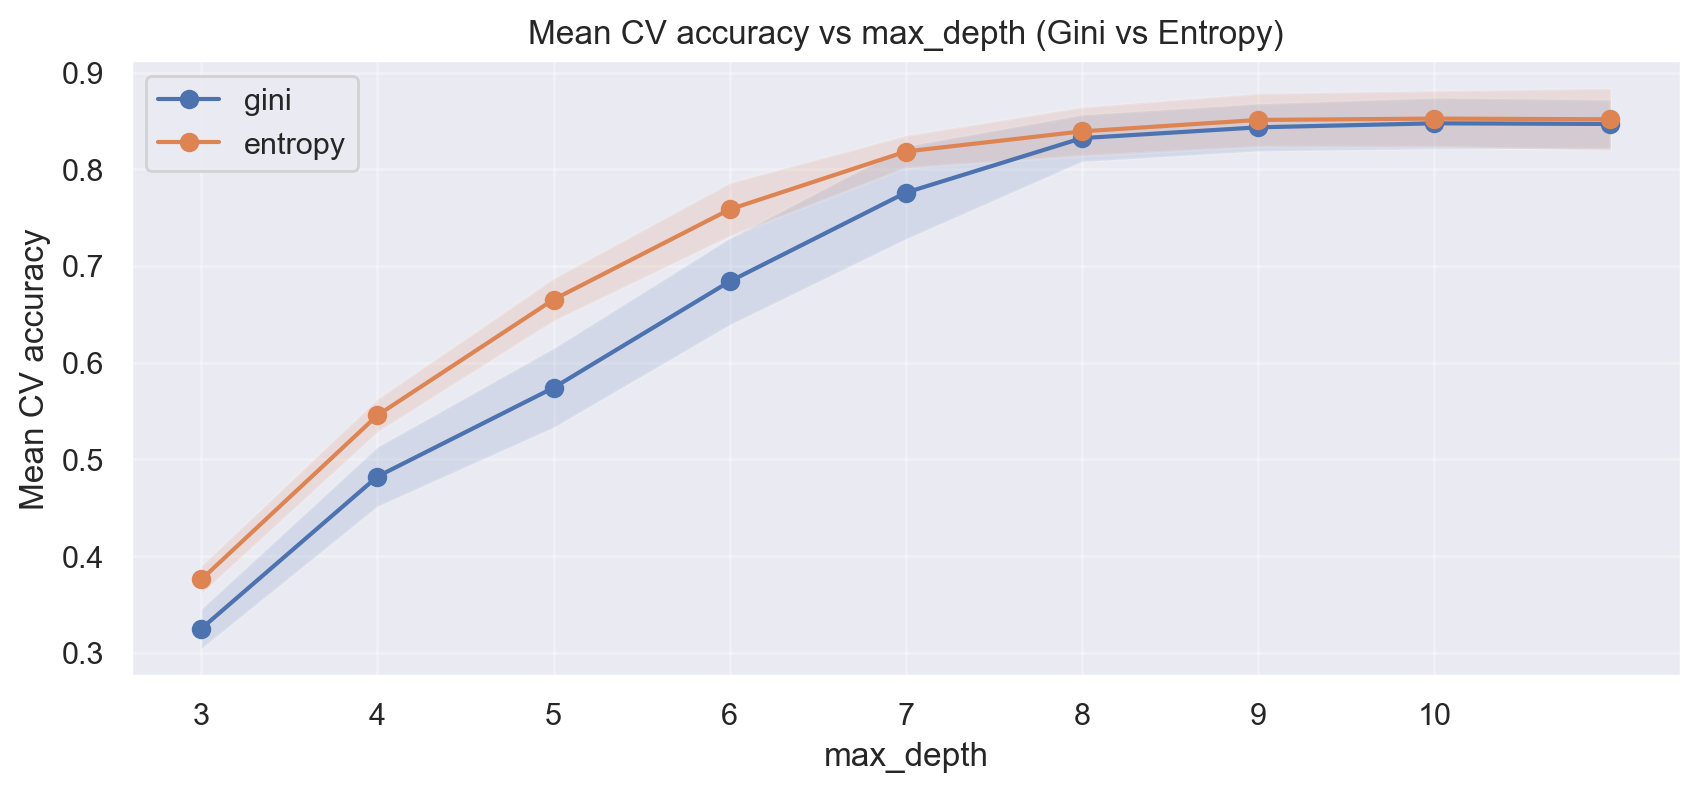

In [81]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
depth_grid = {"max_depth": list(range(3, 12))}
criteria = ["gini", "entropy"]

grids = {}
curves = {}

for crit in criteria:
    grid = GridSearchCV(
        estimator=DecisionTree(criterion=crit),   # fix criterion here
        param_grid=depth_grid,                    # tune only max_depth
        cv=cv,
        scoring="accuracy",
        n_jobs=4,
        verbose=1,
        return_train_score=False,
    )
    grid.fit(X_train, y_train)

    grids[crit] = grid

    res = pd.DataFrame(grid.cv_results_).sort_values("param_max_depth")
    res["param_max_depth"] = res["param_max_depth"].astype(int)
    curves[crit] = res[["param_max_depth", "mean_test_score", "std_test_score"]]

    print(f"{crit.upper()}: best max_depth = {grid.best_params_['max_depth']}, best CV acc = {grid.best_score_:.4f}")

# Plot mean CV accuracy vs max_depth for both criteria
plt.figure(figsize=(10, 4))

for crit in criteria:
    dfc = curves[crit]
    depths = dfc["param_max_depth"].values
    means = dfc["mean_test_score"].values
    stds = dfc["std_test_score"].values

    plt.plot(depths, means, marker="o", label=crit)
    plt.fill_between(depths, means - stds, means + stds, alpha=0.15)

plt.xlabel("max_depth")
plt.ylabel("Mean CV accuracy")
plt.title("Mean CV accuracy vs max_depth (Gini vs Entropy)")
plt.xticks(list(range(3, 11)))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Both criteria tell a pretty consistent story on the `digits` dataset: **deeper trees help**. As we increase `max_depth`, the mean cross-validated accuracy steadily improves and then starts to level off near the upper end of our search range.

More specifically:

* With **Gini**, the best depth in our grid is `max_depth = 10`, reaching a best mean CV accuracy of about **0.8476**.
* With **Entropy**, the best depth is also `max_depth = 10`, but it achieves a slightly higher best mean CV accuracy of about **0.8524**.

So in this experiment, **entropy edges out gini**, but only by a small margin (roughly half a percentage point). In practice, that means the split criterion can influence the learned tree (and its accuracy), but here the bigger driver of performance is simply allowing enough depth for the tree to capture the structure of the digit patterns.


Now we train a tree on `(X_train, y_train)` using the best settings we found (`max_depth=10`, `criterion="entropy"`) and then evaluate its accuracy on the test split `(X_test, y_test)`:



In [82]:
clf = DecisionTree(max_depth=10, criterion="entropy")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8833333333333333

Since `predict_proba` returns a probability vector for each test instance, we can also average these vectors across all samples in `X_test`.  
This gives us the model’s *overall* class distribution on the test set (and we can also look at the largest mean probability):


In [83]:
probs = clf.predict_proba(X_test)
mean_probs = np.mean(probs, axis=0)
print(mean_probs, "\n", max(mean_probs))

[0.09166667 0.0794686  0.09907407 0.08611111 0.125      0.12083333
 0.08055556 0.09675926 0.10571659 0.11481481] 
 0.125


### **2) Regression**

Now let’s check that our implementation also works for a **regression** task.

We’ll generate a simple 1D regression dataset using `make_regression`, split it into train/test parts, and train our custom `DecisionTree` with a regression criterion (`criterion="mad_median"`).  
Then we’ll evaluate the predictions using **mean squared error (MSE)** and visualize the result by plotting:

- the **true target values** in the test set, and  
- the tree’s **predicted values** (which should look piecewise-constant, since each leaf predicts a single number).

Let’s run the code and see how the regression tree behaves.


Mean Squared Error: 165.7607358208333


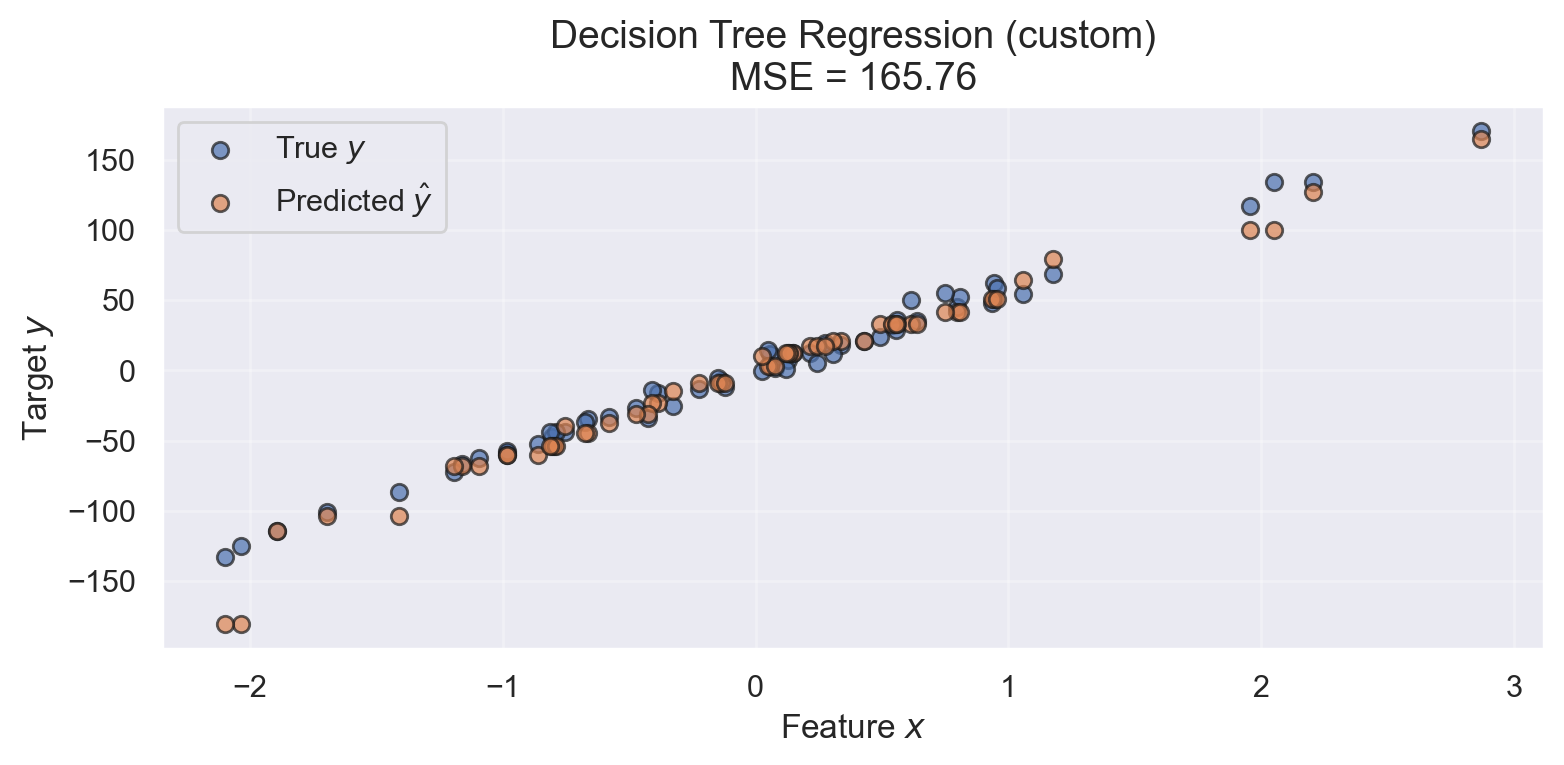

In [84]:
from sklearn.datasets import make_regression

# Generate a simple 1D regression dataset
X, y = make_regression(
    n_features=1,
    n_samples=200,
    bias=0,
    noise=5,
    random_state=RANDOM_STATE
)

# Split into train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

# Train our custom DecisionTree in regression mode
# (criterion="mad_median" switches the tree into regression behavior in our implementation)
reg = DecisionTree(max_depth=6, criterion="mad_median")
reg.fit(X_train, y_train)

# Predict on the test set
y_pred = reg.predict(X_test)

# Evaluate with Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot true targets vs tree predictions
plt.figure(figsize=(8, 4))
plt.scatter(X_test[:, 0], y_test, s=35, alpha=0.7, edgecolor="k", label="True $y$")
plt.scatter(X_test[:, 0], y_pred, s=35, alpha=0.7, edgecolor="k", label="Predicted $\\hat{y}$")
plt.title("Decision Tree Regression (custom)\nMSE = {:.2f}".format(mse), fontsize=14)
plt.xlabel("Feature $x$", fontsize=12)
plt.ylabel("Target $y$", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


The regression test behaves exactly as expected for a decision tree: predictions are **piecewise-constant**, because every test point falls into some leaf and the leaf returns a single aggregate value (here, based on the training targets in that leaf).  

In the plot, the predicted values track the overall linear trend reasonably well, and the reported MSE (here around **165.76**) gives a quantitative summary of the average squared prediction error on the test split. Overall, this confirms that our custom `DecisionTree` works not only for classification, but also for regression.


The synthetic regression example above is a good sanity check, but it’s also nice to see our custom tree behave on a *real* regression problem.

Next, we’ll load the **Boston Housing** dataset (`lfetch_california_housing`), split it into train/test (`test_size=0.2`, `random_state=17`), and train **shallow regression trees** (`max_depth=2`) using two different split criteria:

- `criterion="variance"`: minimizes mean squared deviation (the “classic” regression-tree choice),
- `criterion="mad_median"`: uses mean absolute deviation from the median (more robust to outliers).

Even with the same depth, these criteria can prefer **different splits**, so we should generally expect **different MSE values** on the test set.



The synthetic regression example above is a good sanity check, but it’s also useful to see how our custom tree behaves on a **real-world regression** task.

Next, we’ll switch to the **California Housing** dataset (`fetch_california_housing`). To keep the runtime reasonable for our *from-scratch* implementation, we’ll randomly subsample a smaller set of observations, then split the data into train/test (`test_size=0.2`, `random_state=17`).

We’ll train two **shallow regression trees** (`max_depth=2`) using different split criteria:

- `criterion="variance"`: the standard regression-tree choice, aiming to reduce the mean squared deviation from the mean;
- `criterion="mad_median"`: mean absolute deviation from the median, which tends to be **more robust to outliers**.

Even with the same maximum depth, these criteria can favor **different thresholds and splits**, so it’s normal to see **different test MSE values** for the two trees.


In [85]:
from sklearn.datasets import fetch_california_housing

RANDOM_STATE = 17

# Load California Housing dataset
housing = fetch_california_housing()
X = housing.data
y = housing.target

rng = np.random.RandomState(17)
sub_idx = rng.choice(len(X), size=5000, replace=False)  # try 2000–5000
X, y = X[sub_idx], y[sub_idx]


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Tree with variance criterion
clf1 = DecisionTree(max_depth=2, criterion="variance", debug=True)
clf1.fit(X_train, y_train)
print("Test MSE (variance):", mean_squared_error(y_test, clf1.predict(X_test)))

# Tree with MAD-from-median criterion
clf2 = DecisionTree(max_depth=2, criterion="mad_median", debug=True)
clf2.fit(X_train, y_train)
print("Test MSE (mad_median):", mean_squared_error(y_test, clf2.predict(X_test)))



DecisionTree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'variance', 'debug': True}
depth = 1, n_samples = 4000
best feature = 0, best threshold = 5.136
Test MSE (variance): 0.9367337994317751

DecisionTree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'mad_median', 'debug': True}
depth = 1, n_samples = 4000
best feature = 0, best threshold = 4.6042
Test MSE (mad_median): 0.9546042868489321


<details>
<summary><span style="color:red">Interpreting the debug output:</span></summary>  


- `{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'variance', 'debug': True}`  
  These are the tree’s hyperparameters:
  - **max_depth = 2**: maximum allowed depth of the tree (root is at depth 1). With this setting, the tree can make at most one split at the root and then stop.
  - **min_samples_split = 2**: a node must contain at least 2 samples to be considered for splitting.
  - **criterion = "variance"**: regression splitting rule that prefers splits with the largest **variance reduction** in the target.
  - **debug = True**: prints diagnostic messages during training.

- `depth = 1, n_samples = 4000`  
  The tree is currently building the **root node** (depth 1), using **4000 training samples** (from the train/test split).

- `best feature = 0, best threshold = 5.136`  
  The best root split uses **feature index 0** and threshold **5.136**:
  - go **left** if `X[:, 0] < 5.136`
  - go **right** otherwise  
  This threshold is chosen because it maximizes the split improvement (variance reduction) at this node.

- `Test MSE (variance): 0.9367`  
  This is the **mean squared error** on the test set:
  
  $$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$
  
  Lower MSE means better test performance.

</detaiils>

On this regression dataset, the two criteria lead to *similar but not identical* trees.

Both runs choose the **same feature at the root** (feature `0`), but the **optimal threshold differs**:

* with `criterion="variance"` the first split is at about `5.136`,
* with `criterion="mad_median"` the first split is at about `4.6042`.

That small change already produces a measurable difference on the test set:

* **Test MSE (variance):** 0.9367
* **Test MSE (mad_median):** 0.9546

So in this experiment, **variance** performs slightly better (lower MSE), but the gap is small. Both criteria are capturing the same coarse structure, just with slightly different split choices.

### **Cross-validating `max_depth` and the regression criterion**

Picking `max_depth=2` was arbitrary, so we’ll tune it properly using **5-fold cross-validation** with `GridSearchCV`.
Since this is a regression problem (continuous targets), we use `KFold` (not `StratifiedKFold`), and we evaluate models with `scoring="neg_mean_squared_error"`.

We search over:

* `max_depth` in `range(2, 9)`
* `criterion` in `{"variance", "mad_median"}`


Fitting 5 folds for each of 7 candidates, totalling 35 fits
VARIANCE: best max_depth = 7, best CV MSE = 0.5559
Fitting 5 folds for each of 7 candidates, totalling 35 fits
MAD_MEDIAN: best max_depth = 6, best CV MSE = 0.5353


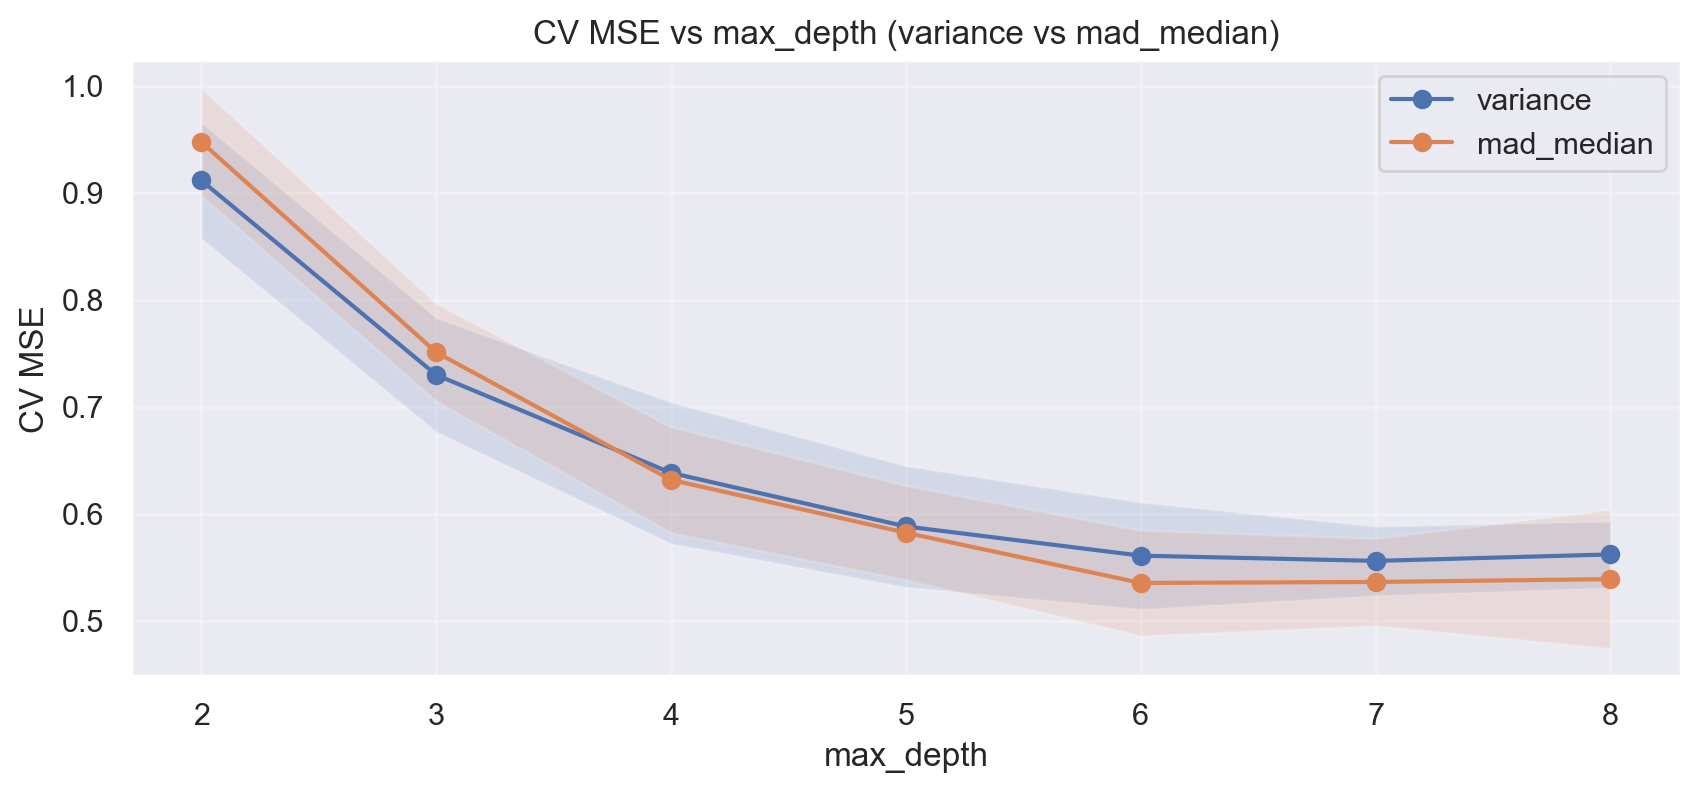

In [86]:
cv = KFold(n_splits=5, shuffle=True, random_state=17)
depth_grid = {"max_depth": list(range(2, 9))}
criteria = ["variance", "mad_median"]

grids = {}
curves = {}

for crit in criteria:
    grid = GridSearchCV(
        estimator=DecisionTree(criterion=crit, debug=False),  # fix criterion here
        param_grid=depth_grid,                                # tune only max_depth
        cv=cv,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1,
        return_train_score=False,
    )
    grid.fit(X_train, y_train)

    grids[crit] = grid

    res = pd.DataFrame(grid.cv_results_).sort_values("param_max_depth")
    res["param_max_depth"] = res["param_max_depth"].astype(int)

    # Convert neg-MSE to MSE for readability
    res["mean_mse"] = -res["mean_test_score"]
    res["std_mse"] = res["std_test_score"]  # std is for neg-MSE, same magnitude

    curves[crit] = res[["param_max_depth", "mean_mse", "std_mse"]]

    print(f"{crit.upper()}: best max_depth = {grid.best_params_['max_depth']}, best CV MSE = {-grid.best_score_:.4f}")

# Plot MSE vs max_depth for both criteria
plt.figure(figsize=(10, 4))

for crit in criteria:
    dfc = curves[crit]
    depths = dfc["param_max_depth"].values
    means = dfc["mean_mse"].values
    stds = dfc["std_mse"].values

    plt.plot(depths, means, marker="o", label=crit)
    plt.fill_between(depths, means - stds, means + stds, alpha=0.15)

plt.xlabel("max_depth")
plt.ylabel("CV MSE")
plt.title("CV MSE vs max_depth (variance vs mad_median)")
plt.xticks(list(range(2, 9)))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


On this regression task, cross-validation shows that **both criteria benefit from increasing `max_depth` at first**, but the improvements **taper off around depth 6–7** (the CV MSE curve flattens and even slightly wiggles afterward).

The two criteria behave similarly overall, but **`mad_median` comes out slightly better in this experiment**:

* **Best for `variance`:** `max_depth = 7`, **best CV MSE ≈ 0.5559**
* **Best for `mad_median`:** `max_depth = 6`, **best CV MSE ≈ 0.5353**

So, even though both criteria are capturing the same coarse structure (same general curve shape), **`mad_median` achieves a lower cross-validated error with a slightly shallower tree**, suggesting it’s a bit more robust here (and may be less sensitive to outliers). If you had to pick one configuration from these results, **`criterion="mad_median", max_depth=6`** is the best-performing choice under CV MSE.


## **Conclusion**

The main outcome of this project is a fully functional **decision tree built from scratch**, which makes the training logic explicit: evaluating candidate splits, selecting the best threshold under a chosen impurity measure, and recursively growing the tree while controlling complexity through stopping rules such as maximum depth. Testing confirms that the implementation behaves as expected across both tasks. In classification, the tree produces consistent class predictions and probability estimates, and results on benchmark data show that the split criterion can affect early splits and lead to small but measurable performance differences. In regression, the model reproduces the expected **piecewise-constant** behaviour and demonstrates that criterion choice and depth tuning can meaningfully influence error.

The real-world cardiovascular disease experiment serves as an additional validation: a tuned tree reaches roughly **0.73 accuracy**, and the learned rules emphasize clinically relevant signals (notably **systolic blood pressure**), reinforcing the interpretability advantage of decision trees. Overall, the key takeaway is that implementing the model from scratch provides a deeper understanding of how decision trees work in practice, and why design choices: criterion, depth, and preprocessing, directly shape both performance and interpretability.
